# Automated Annotation Workflow

This workflow uses the auto_annot tools from besca to newly annotate a scRNAseq dataset based on one or more preannotated datasets. Ideally, these datasets come from a similar tissue and condition.

We use supervised machine learning methods to annotate each individual cell utilizing methods like support vector machines (SVM) or logistic regression.

First, the traning dataset(s) and the testing dataset are loaded from h5ad files or made available as adata objects. Next, the training and testing datasets are corrected using scanorama, and the training datasets are then merged into one anndata object. Then, the classifier is trained utilizing the merged training data. Finally, the classifier is applied to the testing dataset to predict the cell types. If the testing dataset is already annotated (to test the algorithm), a report including confusion matrices can be generated.

In [1]:
import besca as bc

/home/luis/anaconda3/envs/bescafinal/lib/python3.8/site-packages/scanpy/api/__init__.py:3: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  warnings.warn(


In [2]:
import os

### test load datasets with scvelo

Apparently the scv loader makes sure the adata objects are all in comparable format whereas the sc loader loads them as is.

In [3]:
adata_test = bc.datasets.pbmc3k_processed()

In [4]:
adata_test_orig = bc.datasets.pbmc3k_processed()

In [5]:
adata_train1 = bc.datasets.Granja2019_processed()

In [6]:
adata_train2 = bc.datasets.Kotliarov2020_processed()

In [7]:
train001 = adata_train1.concatenate(adata_train2) #just for testing

In [8]:
adata_train_list = [adata_train1, adata_train2]

## Parameter specification

Give your analysis a name.

In [9]:
analysis_name = 'auto_annot_pubimage_optimised_classes' # The analysis name will be used to name the output files

Specify column name of celltype annotation you want to train on.

### choose right level of annotation

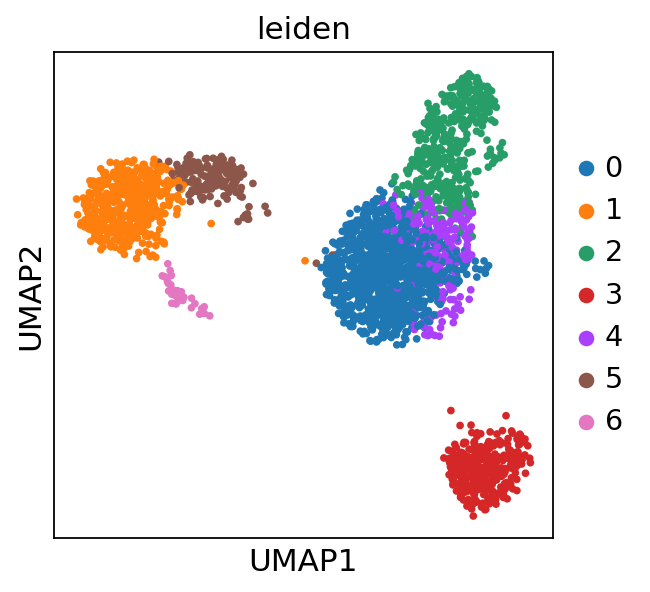

In [46]:
sc.pl.umap(adata_predicted, color = "leiden")

In [10]:
adata_test.obs.celltype2.unique

<bound method Series.unique of AAACATACAACCAC-1    CD8-positive, alpha-beta T cell
AAACATTGAGCTAC-1                             B cell
AAACATTGATCAGC-1    CD4-positive, alpha-beta T cell
AAACCGTGCTTCCG-1                 classical monocyte
AAACGCACTGGTAC-1    CD4-positive, alpha-beta T cell
                                 ...               
TTTCGAACTCTCAT-1                 classical monocyte
TTTCTACTGAGGCA-1                             B cell
TTTCTACTTCCTCG-1                             B cell
TTTGCATGAGAGGC-1                             B cell
TTTGCATGCCTCAC-1    CD4-positive, alpha-beta T cell
Name: celltype2, Length: 2504, dtype: category
Categories (7, object): [B cell, CD4-positive, alpha-beta T cell, CD8-positive, alpha-beta T cell, classical monocyte, cytotoxic CD56-dim natural killer cell, myeloid dendritic cell, non-classical monocyte]>

In [11]:
celltype ='celltype2' # This needs to be a column in the .obs of the training datasets (and test dataset if you want to generate a report)

Choose a method:

- linear: Support Vector Machine with Linear Kernel
- sgd: Support Vector Machine with Linear Kernel using Stochastic Gradient Descent
- rbf: Support Vector Machine with radial basis function kernel. Very time intensive, use only on small datasets.
- logistic_regression: Standard logistic classifier iwth multinomial loss.
- logistic_regression_ovr: Logistic Regression with one versus rest classification.
- logistic_regression_elastic: Logistic Regression with elastic loss, cross validates among multiple l1 ratios.

In [12]:
method = 'logistic_regression'

Specify merge method. Needs to be either scanorama or naive.

In [13]:
merge = 'scanorama' # We recommend to use scanorama here

Decide if you want to use the raw format or highly variable genes. Raw increases computational time and does not necessarily improve predictions.

In [14]:
use_raw = False # We recommend to use False here

You can choose to only consider a subset of genes from a signature set or use all genes.

In [15]:
genes_to_use = 'all' # We suggest to use all here, but the runtime is strongly improved if you select an appropriate gene set

Column names need to be standardised so the function knows which columns to compare.

In [16]:
#adata_test.obs["dblabel"] = adata_test.obs.celltype3_original
#adata_test_orig.obs["dblabel"] = adata_test_orig.obs.celltype3_original

#adata_train_list[1].obs["dblabel"] = adata_train_list[1].obs.celltype3

In [17]:
#adata_test.obs.dblabel.unique()

In [18]:
adata_train_list[0].obs.dblabel.unique()

[naive thymus-derived CD4-positive, alpha-beta ..., classical monocyte, naive B cell, lymphocyte of B lineage, naive thymus-derived CD8-positive, alpha-beta ..., ..., IL7R-max CD8-positive, alpha-beta cytotoxic T ..., hematopoietic multipotent progenitor cell, myeloid leukocyte, basophil, plasma cell]
Length: 25
Categories (25, object): [naive thymus-derived CD4-positive, alpha-beta ..., classical monocyte, naive B cell, lymphocyte of B lineage, ..., hematopoietic multipotent progenitor cell, myeloid leukocyte, basophil, plasma cell]

In [19]:
adata_test.var.dtypes

ENSEMBL           object
SYMBOL          category
n_cells            int64
total_counts     float32
frac_reads       float32
mean             float64
std              float64
dtype: object

In [20]:
adata_train_list[0].var.dtypes

ENSEMBL           object
SYMBOL            object
feature_type    category
n_cells            int64
total_counts     float32
frac_reads       float32
dtype: object

In [21]:
adata_train_list[1].var.dtypes

ENSEMBL         category
SYMBOL            object
feature_type    category
n_cells          float64
total_counts     float32
frac_reads       float32
dtype: object

## Correct datasets (e.g. using scanorama) and merge training datasets

This function merges training datasets, removes unwanted genes, and if scanorama is used corrects for datasets.

In [22]:
adata_train, adata_test_corrected = bc.tl.auto_annot.merge_data(adata_train_list, adata_test, genes_to_use = genes_to_use, merge = merge)

merging with scanorama
using scanorama rn
Found 207 genes among all datasets
[[0.         0.69557349 0.47404153]
 [0.         0.         0.99201278]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)
integrating training set


## Train the classifier

The returned scaler is fitted on the training dataset (to zero mean and scaled to unit variance). The scaling will then be applied to the counts in the testing dataset and then the classifier is applied to the scaled testing dataset (see next step, adata_predict()). This function will run multiple jobs in parallel if if logistic regression was specified as method.

In [23]:
classifier, scaler = bc.tl.auto_annot.fit(adata_train, method, celltype, njobs=10)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:  5.0min finished


## Prediction

If in addition to the most likely class you would like to have all class probabilities returned use the following function. (This is only a sensible choice if using logistic regression.)

In [24]:
adata_predicted = bc.tl.auto_annot.adata_pred_prob(classifier = classifier, scaler = scaler, adata_pred = adata_test_corrected, adata_orig = adata_test_orig, threshold = 0.0)

## Output

The adata object that includes the predicted cell type annotation can be written out as h5ad file.

In [25]:
#adata_predicted.write('./adata_predicted_opt_22072020.h5ad')

... storing 'auto_annot' as categorical


If the testing dataset included already a cell type annotation, a report can be generated and written, which includes metrics,  confusion matrices and comparative umap plots.

In [26]:
adata_predicted.obs

CELL  percent_mito       experiment  n_counts  \
AAACATACAACCAC-1  AAACATACAACCAC-1      0.030153  pbmc3k_filtered    2421.0   
AAACATTGAGCTAC-1  AAACATTGAGCTAC-1      0.037936  pbmc3k_filtered    4903.0   
AAACATTGATCAGC-1  AAACATTGATCAGC-1      0.008892  pbmc3k_filtered    3148.0   
AAACCGTGCTTCCG-1  AAACCGTGCTTCCG-1      0.017431  pbmc3k_filtered    2639.0   
AAACGCACTGGTAC-1  AAACGCACTGGTAC-1      0.016636  pbmc3k_filtered    2163.0   
...                            ...           ...              ...       ...   
TTTCGAACTCTCAT-1  TTTCGAACTCTCAT-1      0.021092  pbmc3k_filtered    3461.0   
TTTCTACTGAGGCA-1  TTTCTACTGAGGCA-1      0.009283  pbmc3k_filtered    3447.0   
TTTCTACTTCCTCG-1  TTTCTACTTCCTCG-1      0.021971  pbmc3k_filtered    1684.0   
TTTGCATGAGAGGC-1  TTTGCATGAGAGGC-1      0.020508  pbmc3k_filtered    1022.0   
TTTGCATGCCTCAC-1  TTTGCATGCCTCAC-1      0.008060  pbmc3k_filtered    1985.0   

                  n_genes leiden  score_lymphocyte_scanpy  \
AAACATACAACCAC-1      781      5                 0.365830   
AAACATTGAGCTAC-1     1352      1                 0.404063   
AAACATTGATCAGC-1     1131      6                 0.722883   
AAACCGTGCTTCCG-1      960      0                -0.028641   
AAACGCACTGGTAC-1      782     10                -1.325377   
...                   ...    ...                      ...   
TTTCGAACTCTCAT-1     1155      0                -1.394863   
TTTCTACTGAGGCA-1     1227      1                -1.509175   
TTTCTACTTCCTCG-1      622      1                 0.692867   
TTTGCATGAGAGGC-1      454      1                -0.857408   
TTTGCATGCCTCAC-1      724     11                -1.300216   

                  score_myeloid_scanpy  score_Bcell_scanpy  \
AAACATACAACCAC-1             -1.269378           -0.312056   
AAACATTGAGCTAC-1             -0.850506            1.221926   
AAACATTGATCAGC-1             -0.795757           -0.311508   
AAACCGTGCTTCCG-1              2.001340           -0.336593   
AAACGCACTGGTAC-1             -1.325377           -0.213229   
...                                ...                 ...   
TTTCGAACTCTCAT-1              3.353787           -0.247567   
TTTCTACTGAGGCA-1             -1.055424            1.252956   
TTTCTACTTCCTCG-1             -0.598499            1.580936   
TTTGCATGAGAGGC-1             -0.857408            3.220181   
TTTGCATGCCTCAC-1             -0.101524           -0.156380   

                  score_Tcells_scanpy  ...  hematopoietic cell  \
AAACATACAACCAC-1             0.742338  ...            0.015458   
AAACATTGAGCTAC-1            -1.033879  ...            0.000045   
AAACATTGATCAGC-1             0.678192  ...            0.005638   
AAACCGTGCTTCCG-1            -1.024017  ...            0.000004   
AAACGCACTGGTAC-1             0.981284  ...            0.005712   
...                               ...  ...                 ...   
TTTCGAACTCTCAT-1            -1.183916  ...            0.000013   
TTTCTACTGAGGCA-1            -1.227544  ...            0.000066   
TTTCTACTTCCTCG-1            -0.812423  ...            0.000052   
TTTGCATGAGAGGC-1            -0.845517  ...            0.000009   
TTTGCATGCCTCAC-1             1.661736  ...            0.006319   

                  hematopoietic multipotent progenitor cell  \
AAACATACAACCAC-1                                   0.019362   
AAACATTGAGCTAC-1                                   0.000007   
AAACATTGATCAGC-1                                   0.000277   
AAACCGTGCTTCCG-1                                   0.000006   
AAACGCACTGGTAC-1                                   0.001309   
...                                                     ...   
TTTCGAACTCTCAT-1                                   0.000037   
TTTCTACTGAGGCA-1                                   0.000004   
TTTCTACTTCCTCG-1                                   0.000026   
TTTGCATGAGAGGC-1                                   0.000005   
TTTGCATGCCTCAC-1                                   0.002948   

                  hematopoietic stem cell  lymphocyte

leiden clustering performed with a resolution of 1


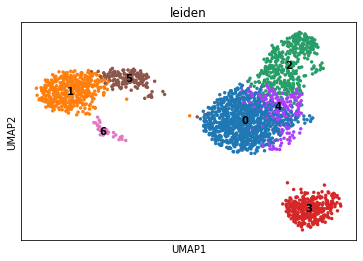

rank genes per cluster calculated using method wilcoxon.
mapping of cells to  leiden exported successfully to cell2labels.tsv
average.gct exported successfully to file
fract_pos.gct exported successfully to file
labelinfo.tsv successfully written out
./labelings/leiden/WilxRank.gct written out
./labelings/leiden/WilxRank.pvalues.gct written out
./labelings/leiden/WilxRank.logFC.gct written out


In [28]:
import scanpy as sc

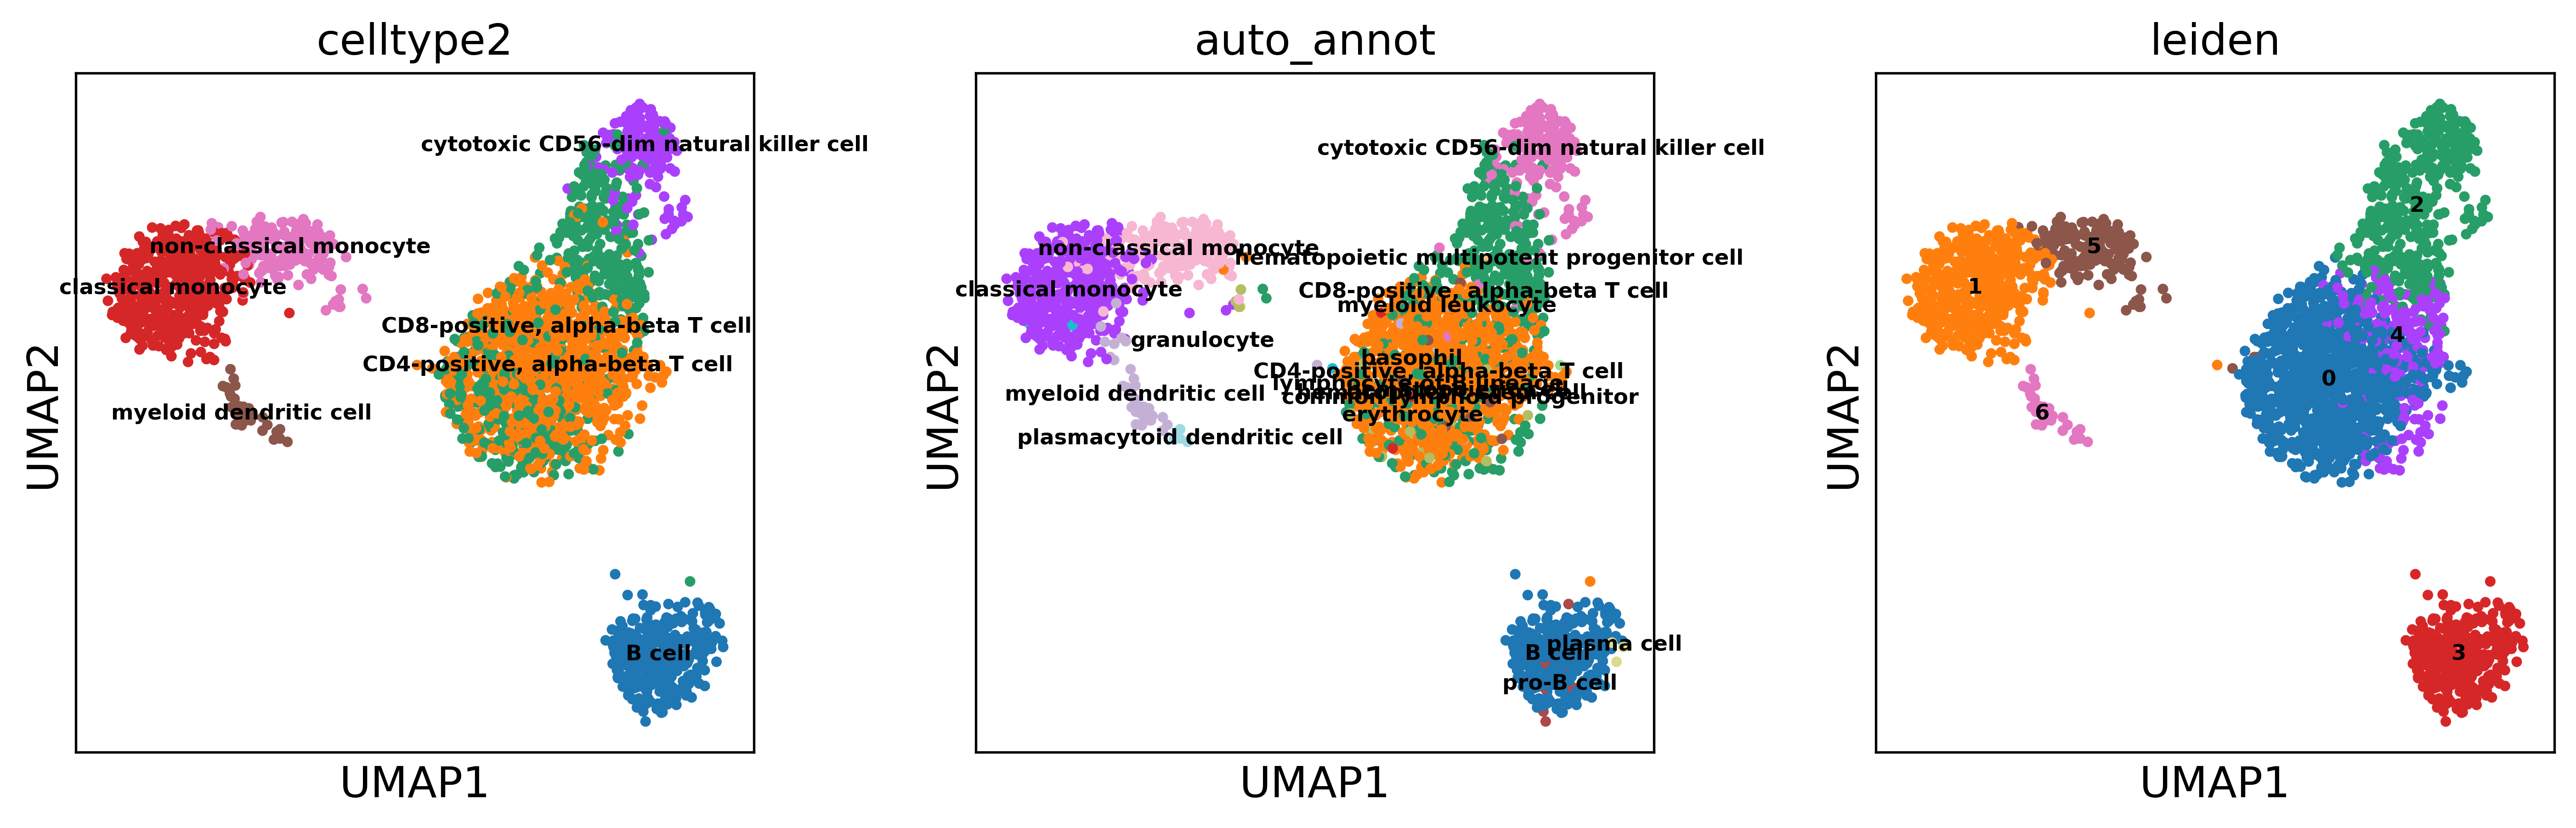

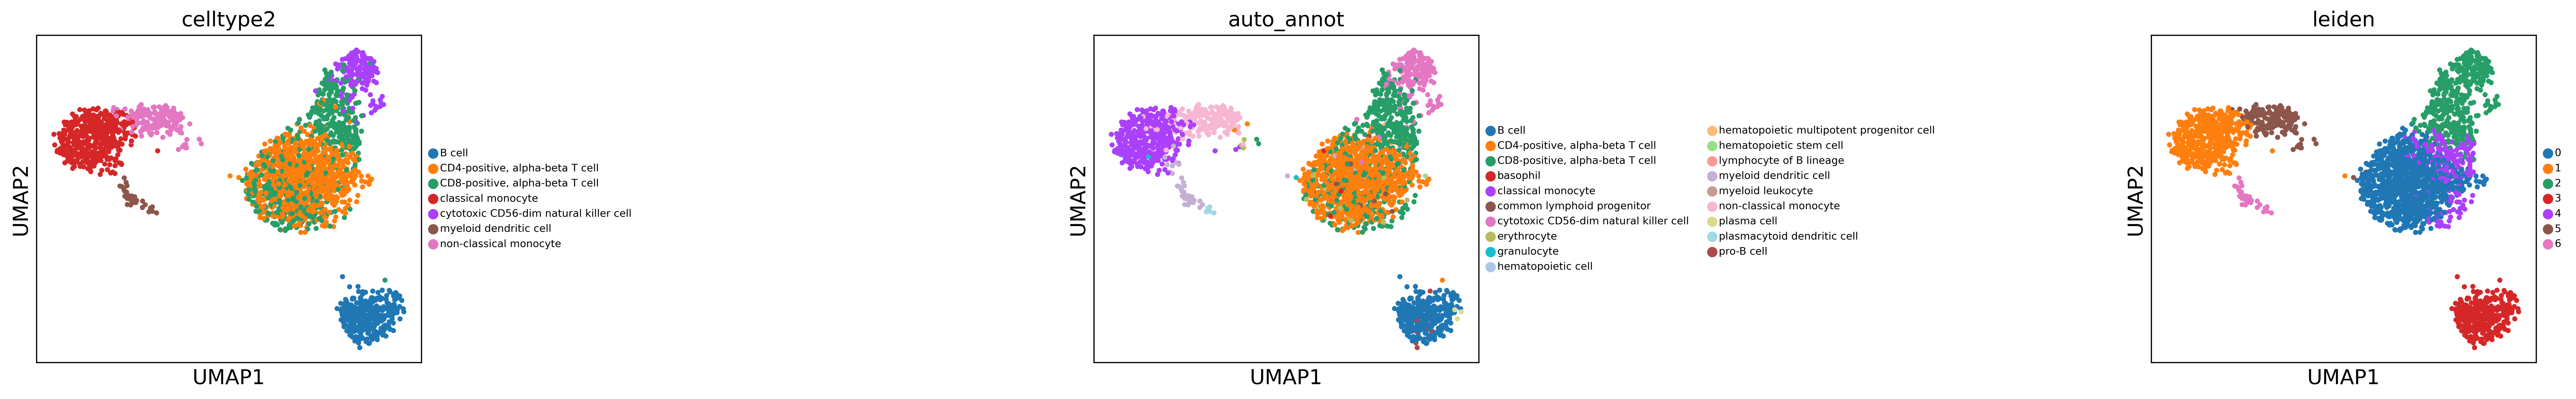

Confusion matrix, without normalization
Normalized confusion matrix


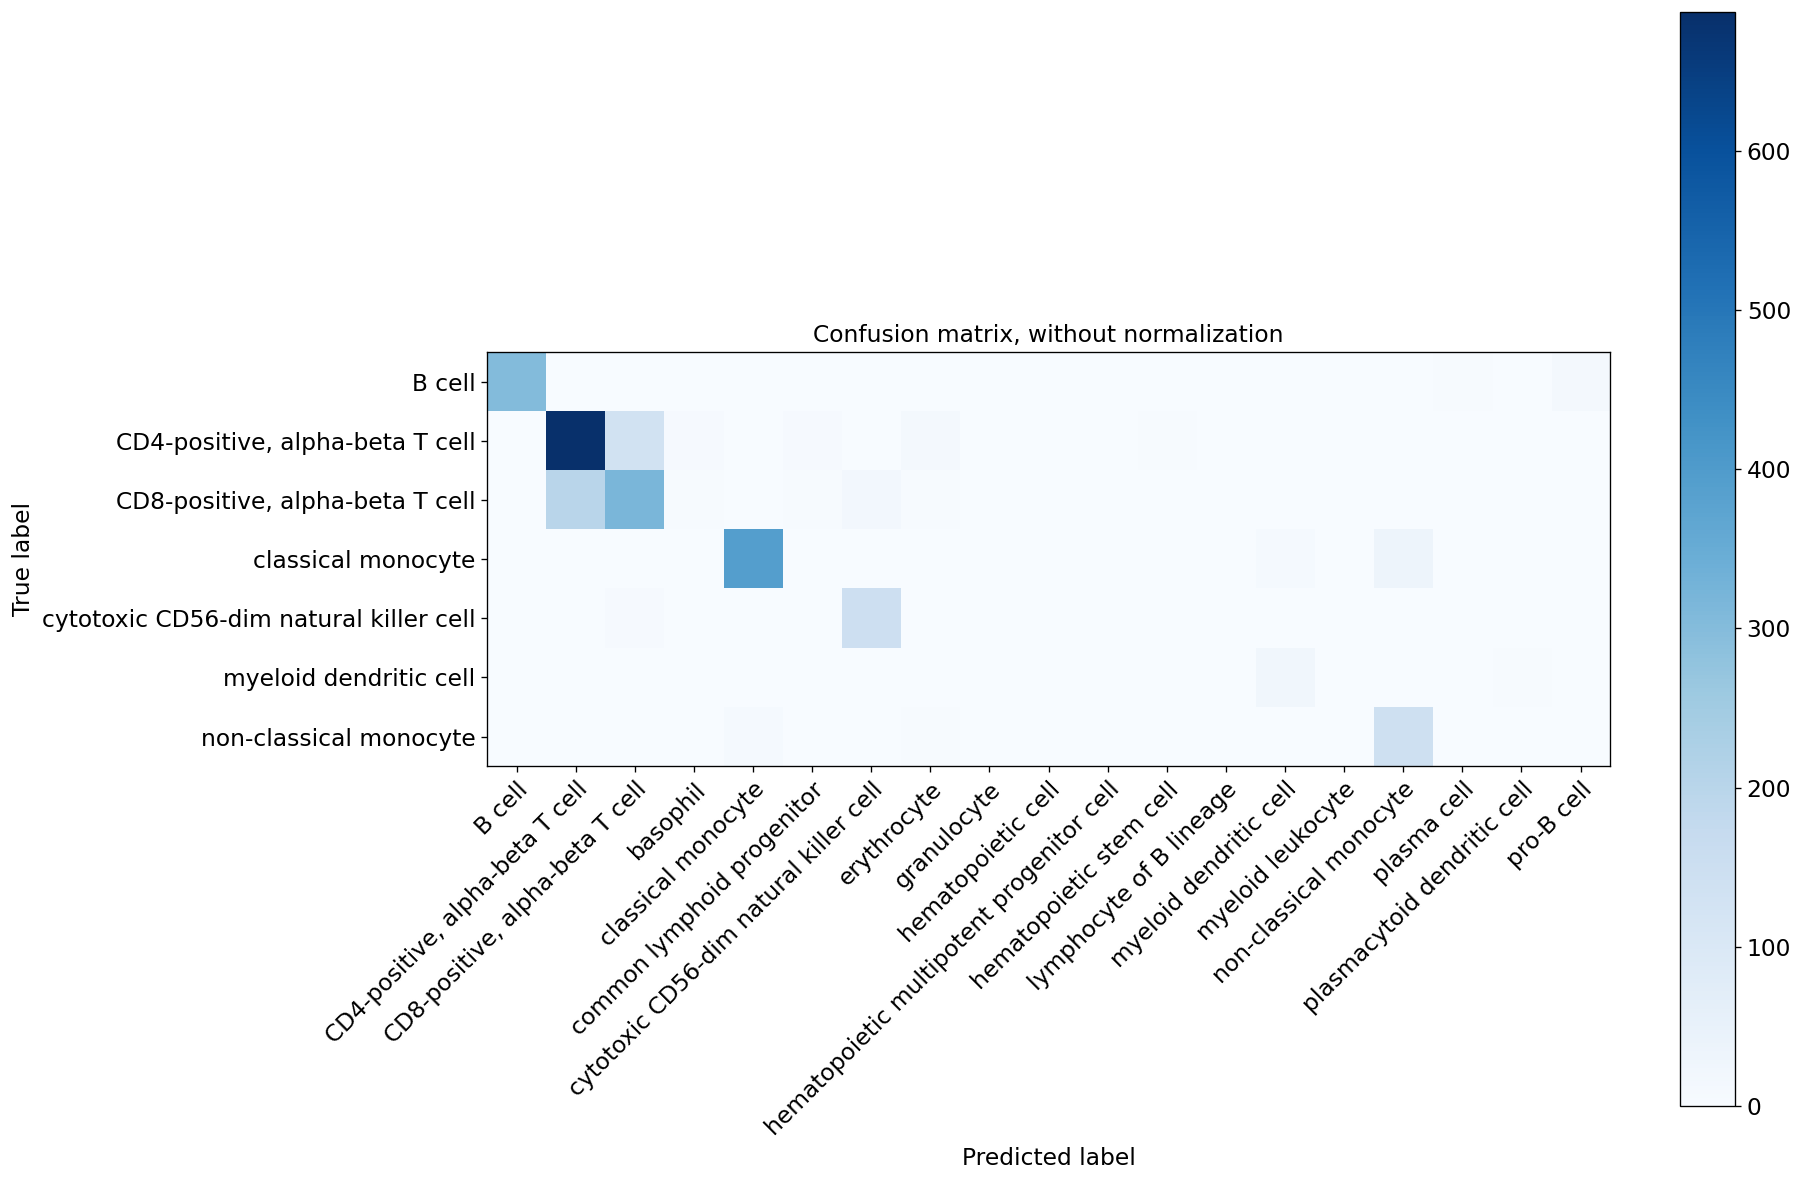

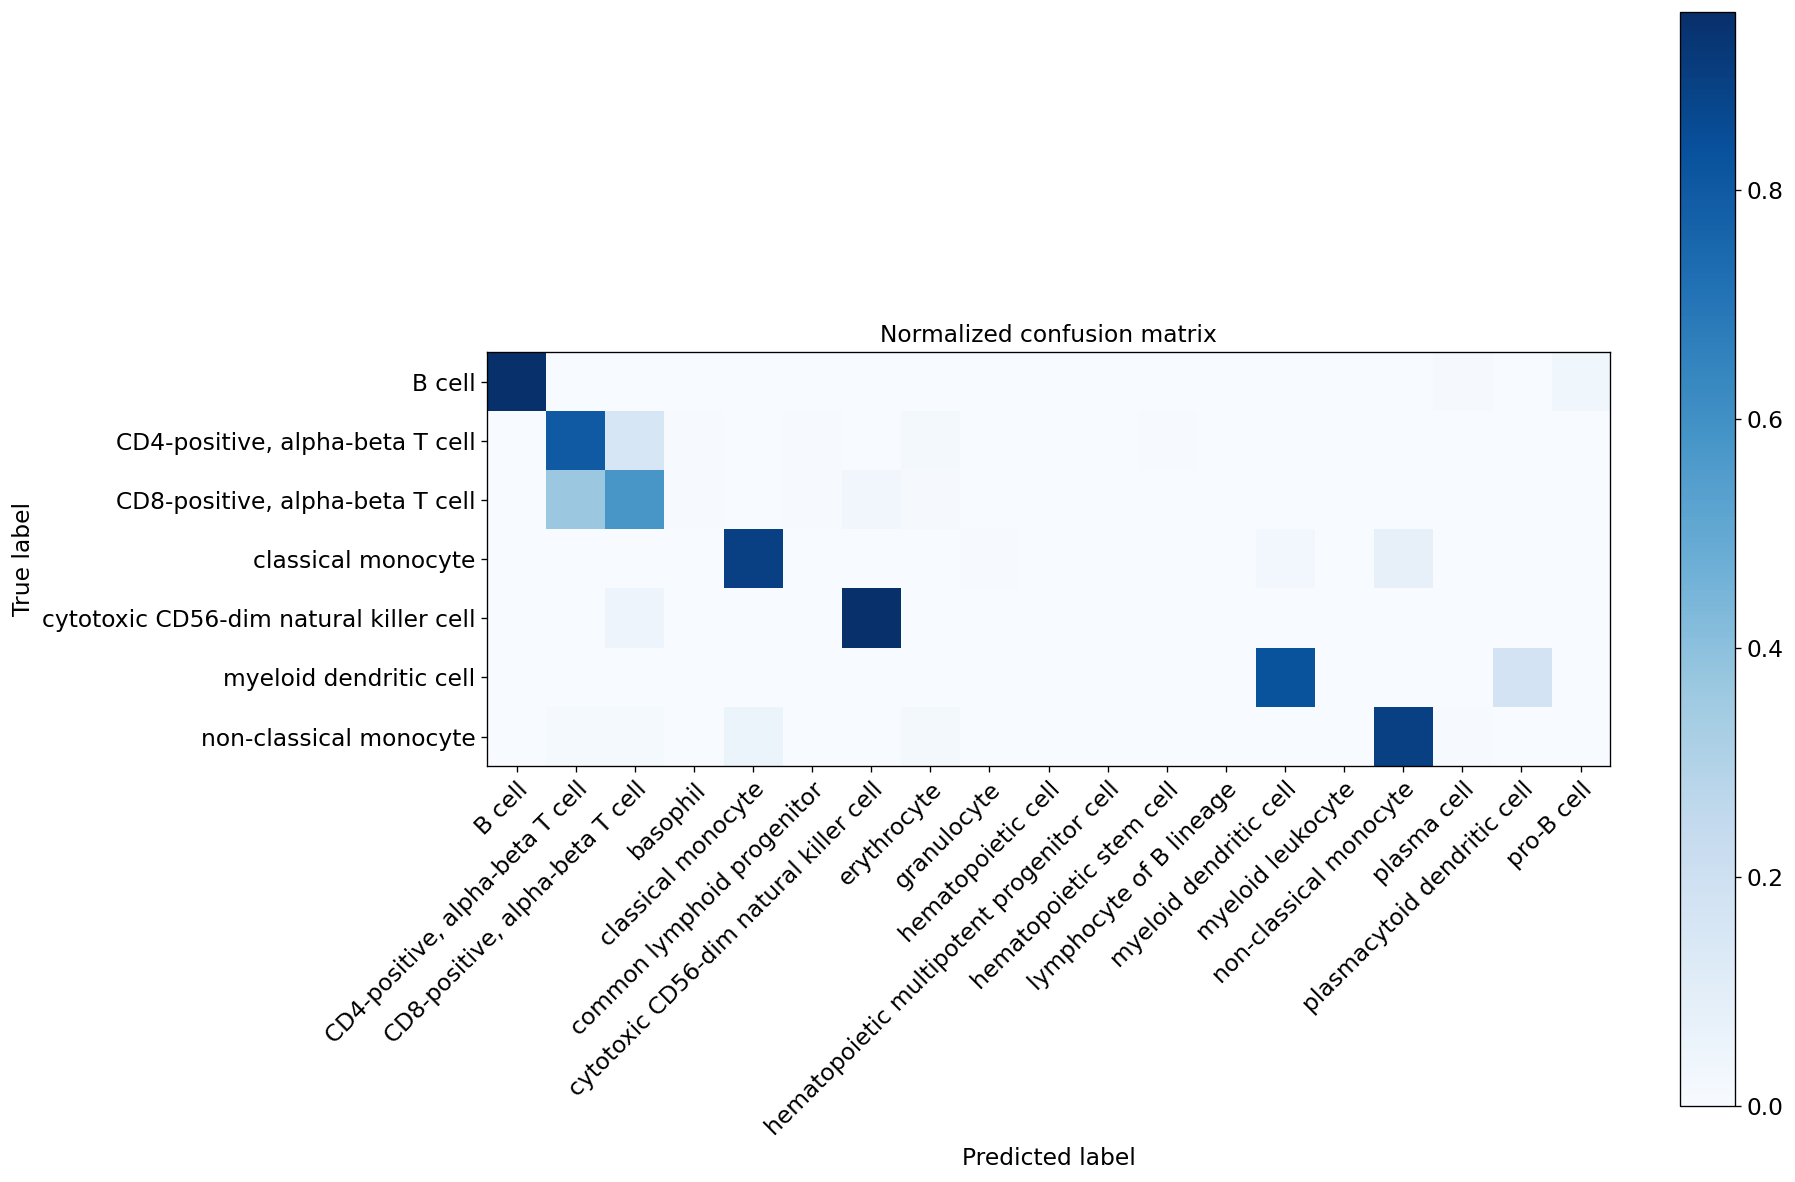

In [29]:
%matplotlib inline
sc.settings.set_figure_params(dpi=90)
bc.tl.auto_annot.report(adata_predicted, celltype, method, analysis_name, False, merge, use_raw, genes_to_use, clustering = 'leiden')

In [32]:
sc.settings.set_figure_params(dpi=80) 
plt.rcParams['svg.fonttype'] = 'none'
sc.pl.umap(adata_predicted, color=[celltype, 'auto_annot', 'leiden'], legend_loc='on data',legend_fontsize=7,  save= '.fig3_ondata_level2.svg')
sc.pl.umap(adata_predicted, color=[celltype, 'auto_annot', 'leiden'],legend_fontsize=7, wspace = 1.4, save = '.fig3_level2.svg')


In [49]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes, celltype,
                          normalize=False,
                          title=None, numbers =False,
                          cmap=plt.cm.Blues, adata_predicted= None, asymmetric_matrix = True): 

    matplotlib.use('Agg')
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if asymmetric_matrix == True:
        class_names =  np.unique(np.concatenate((adata_predicted.obs[celltype], adata_predicted.obs['auto_annot'])))
        class_names_orig = np.unique(adata_predicted.obs[celltype])
        class_names_pred = np.unique(adata_predicted.obs['auto_annot'])
        test_celltypes_ind = np.searchsorted(class_names, class_names_orig)
        train_celltypes_ind = np.searchsorted(class_names, class_names_pred)
        cm=cm[test_celltypes_ind,:][:,train_celltypes_ind]
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(15,15))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax, shrink = 0.8)
    # We want to show all ticks...
    if asymmetric_matrix == True:
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               # ... and label them with the respective list entries
               xticklabels=class_names_pred, yticklabels=class_names_orig,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')
    else:
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               # ... and label them with the respective list entries
               xticklabels=classes, yticklabels=classes,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')
        
    ax.grid(False)
   
    ax.set_xlabel('Predicted label', fontsize = 20)
    ax.set_ylabel('True label', fontsize = 20)
    
    #changes to labelsize
    ax.tick_params(axis='both', which='major', labelsize=20)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    if numbers == True:
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    return ax

Confusion matrix, without normalization
Normalized confusion matrix


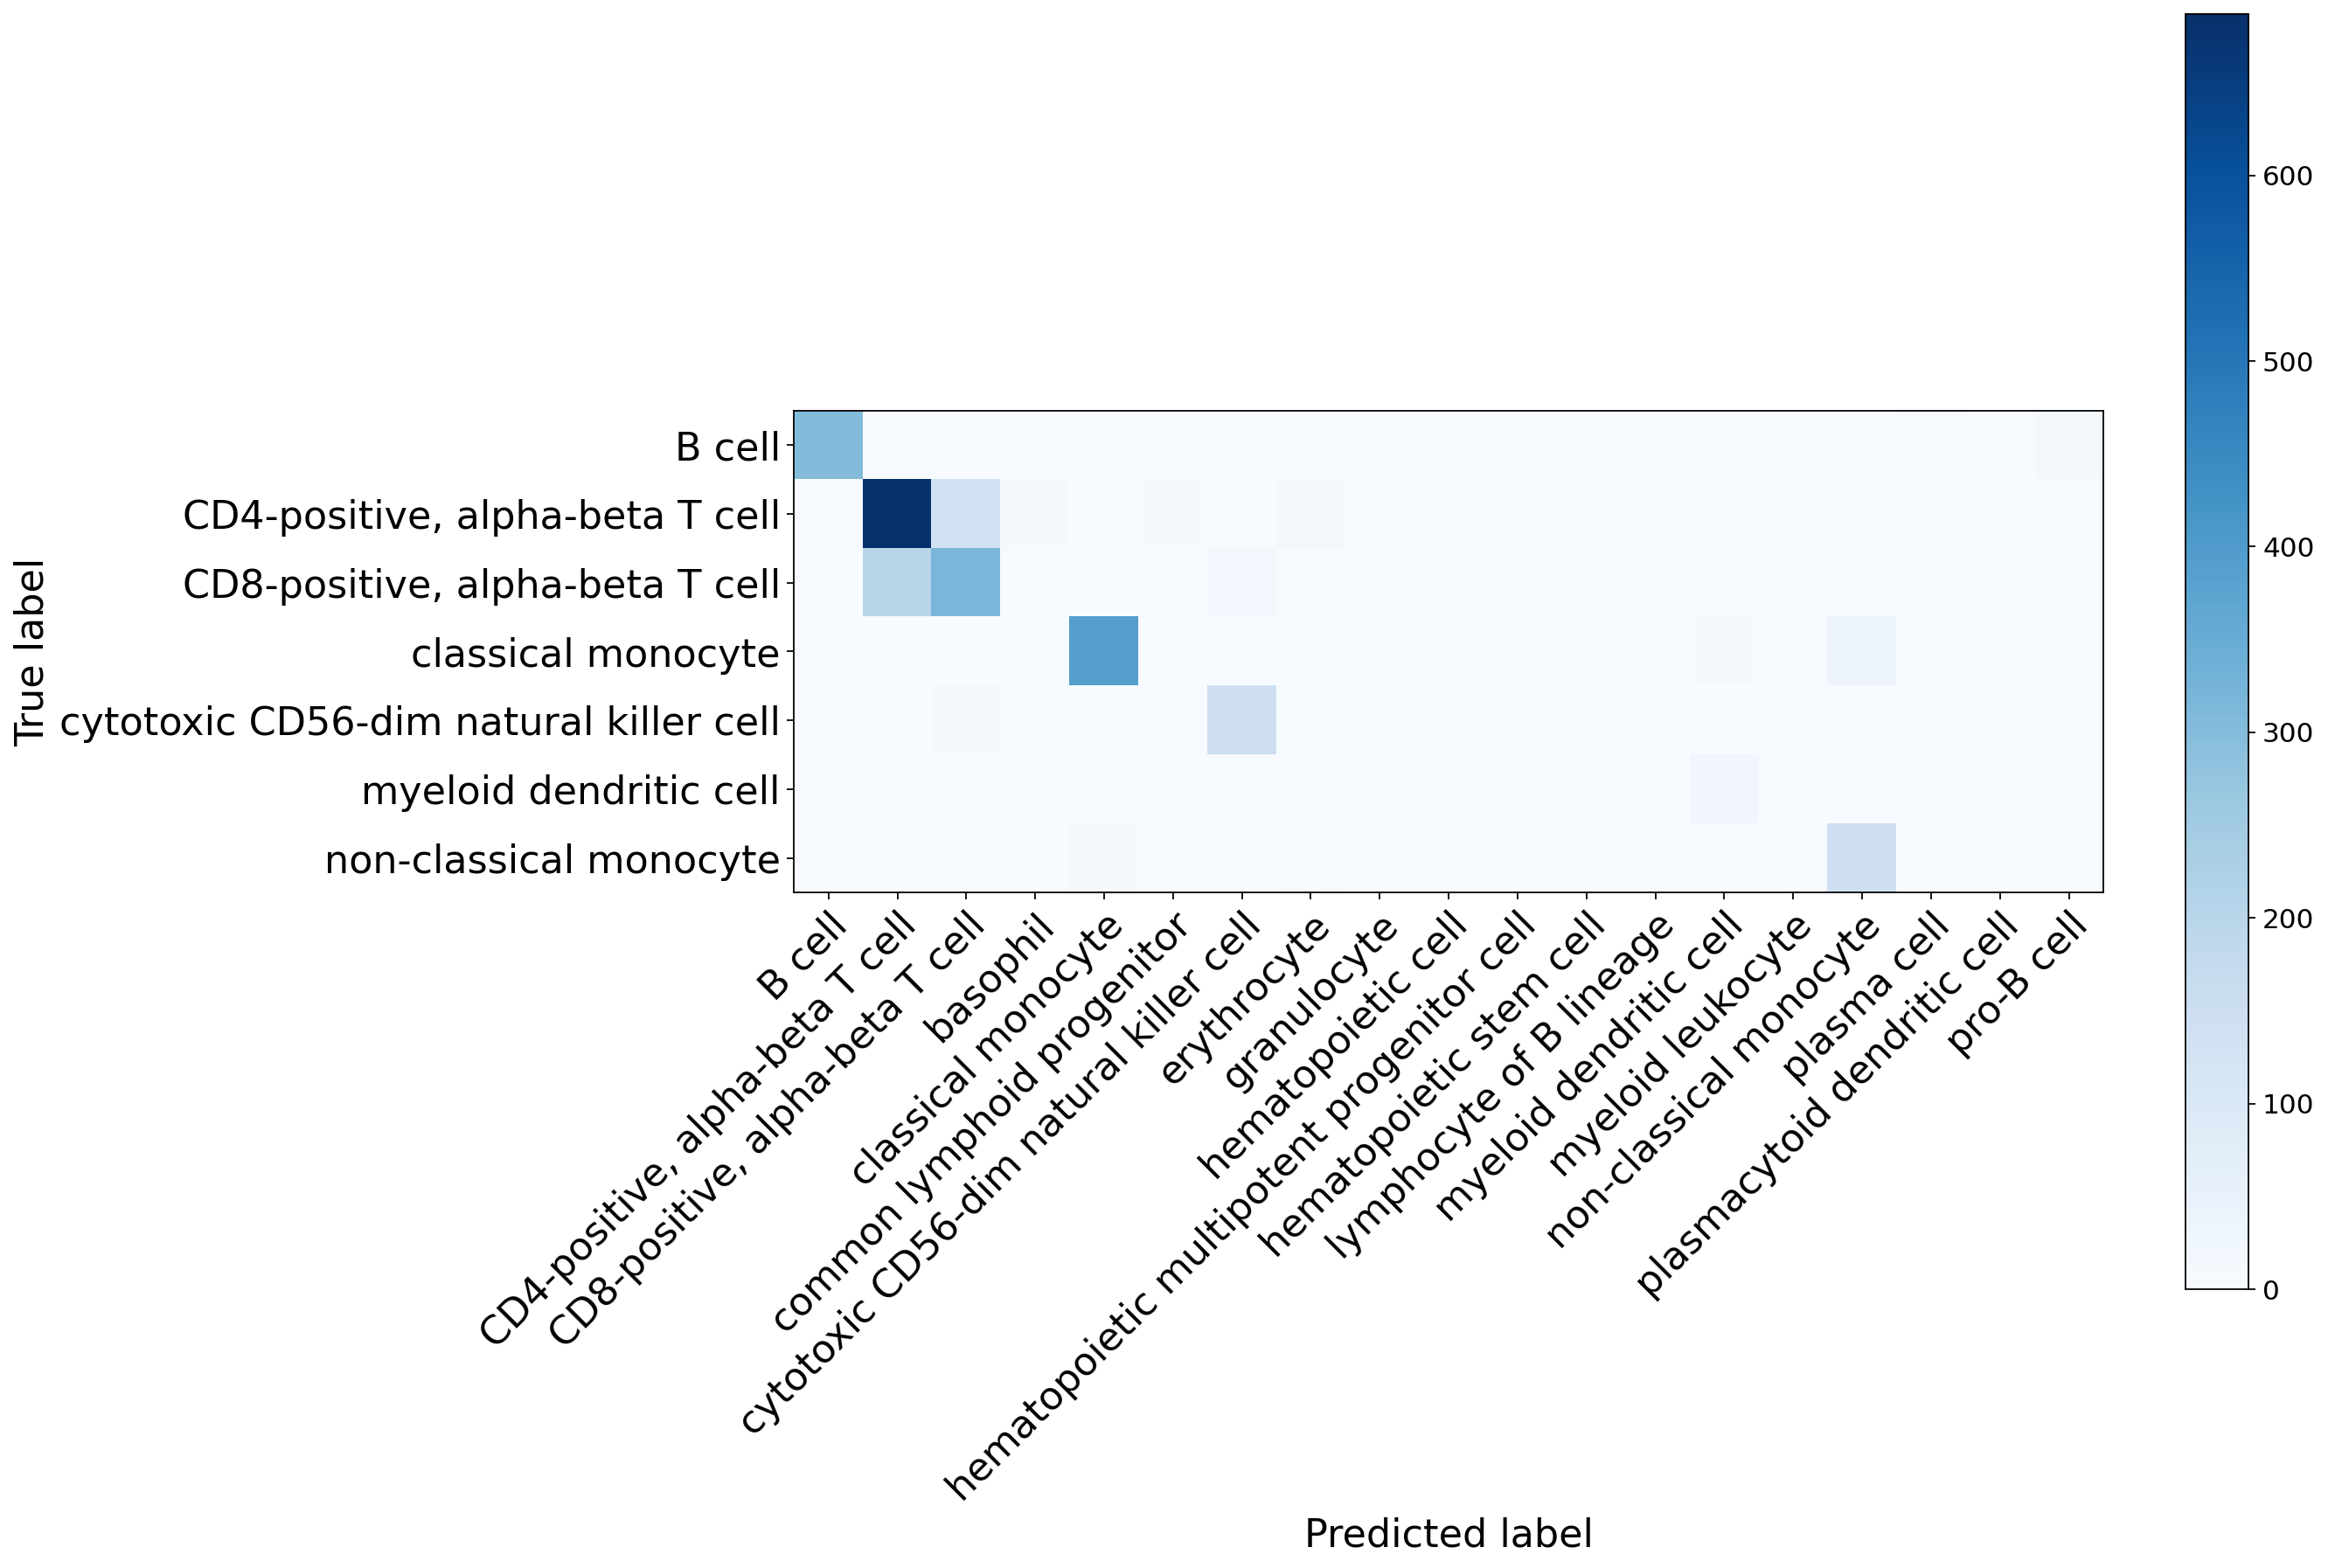

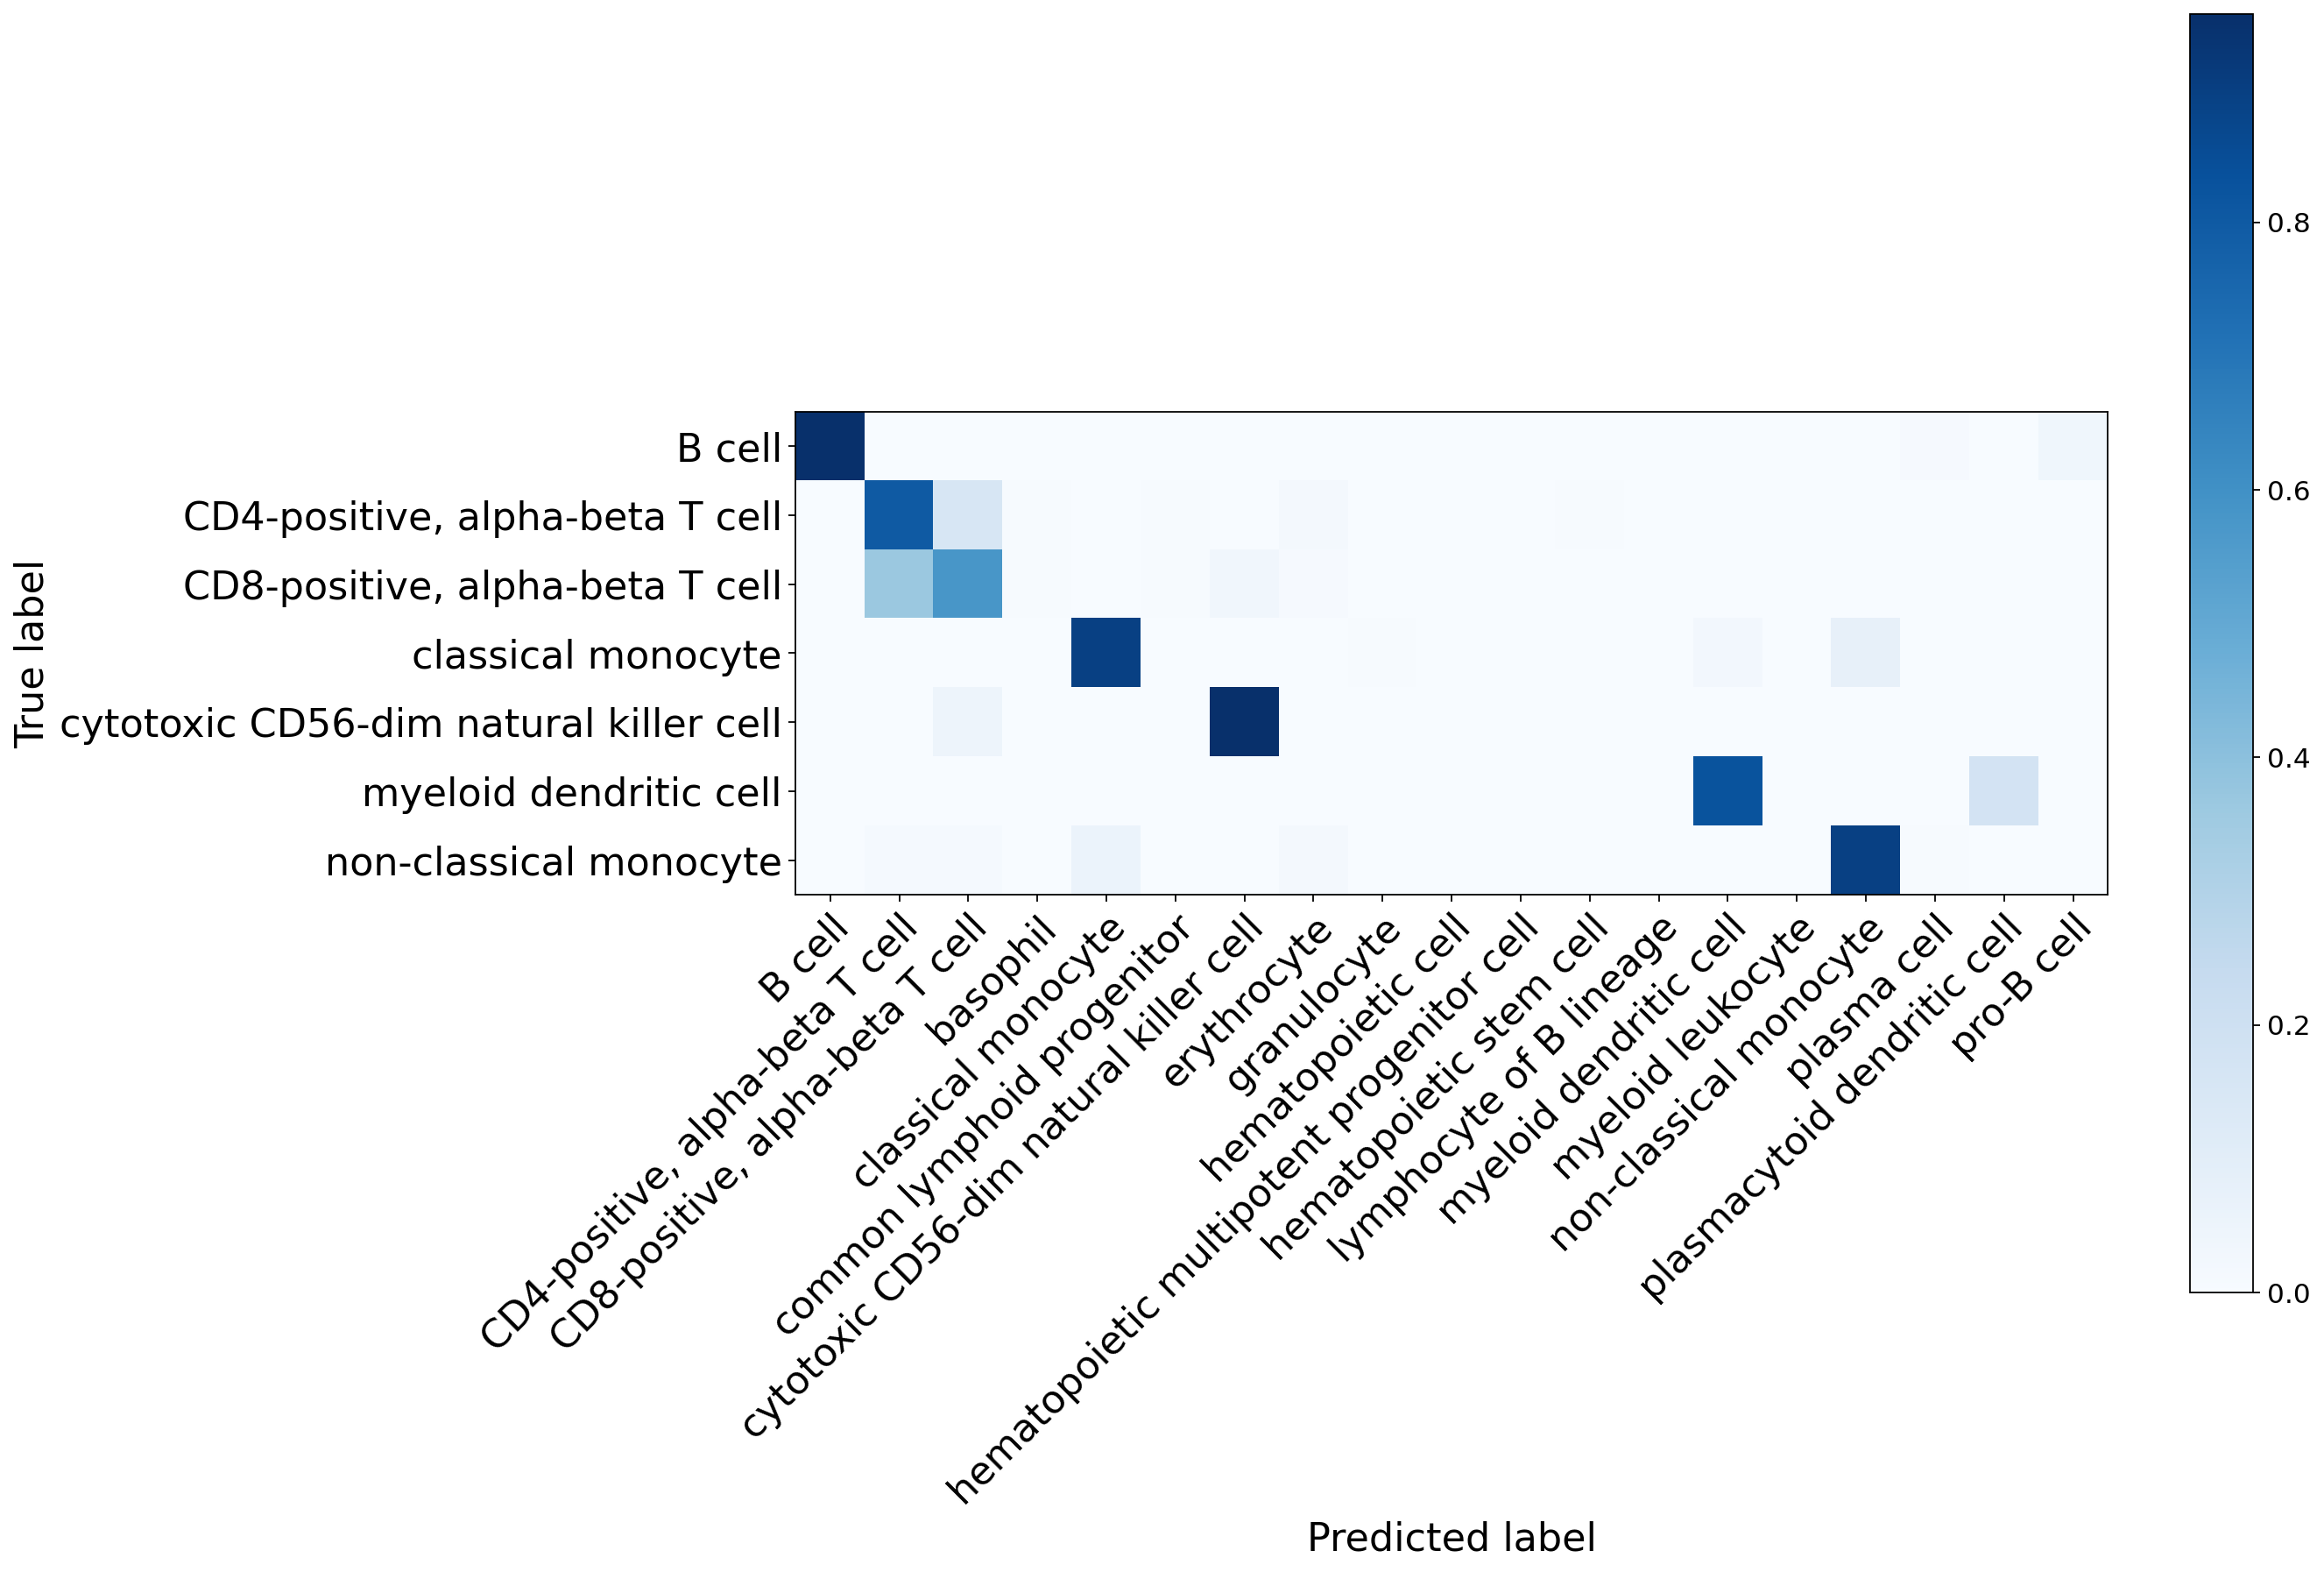

In [34]:
# make conf matrices (4)
sc.settings.set_figure_params(dpi=80) 
plt.rcParams['svg.fonttype'] = 'none'
class_names =  np.unique(np.concatenate((adata_predicted.obs[celltype], adata_predicted.obs['auto_annot'])))
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(adata_predicted.obs[celltype], adata_predicted.obs['auto_annot'], title = " ", classes=class_names, celltype=celltype ,numbers = False, adata_predicted = adata_predicted, asymmetric_matrix = True)
plt.savefig(os.path.join('fig3_confusion_matrix_nonnormalised_level2.svg'))

# Plot normalized confusion matrix with numbers
plot_confusion_matrix(adata_predicted.obs[celltype], adata_predicted.obs['auto_annot'], title = " ", classes=class_names,celltype=celltype,  normalize=True, numbers = False, adata_predicted = adata_predicted, asymmetric_matrix = True)
plt.savefig(os.path.join('fig3_confusion_matrix_normalised_level2.svg'))


# let's use a threshold

In [35]:
analysis_name = 'auto_annot_pubimage_threshold_level2' # The analysis name will be used to name the output files

In [36]:
adata_predicted_threshold = bc.tl.auto_annot.adata_pred_prob(classifier = classifier, scaler = scaler, adata_pred = adata_test_corrected, adata_orig = adata_test_orig, threshold = 0.7)

In [37]:
#adata_predicted_threshold.write('./adata_predicted_opt_threshold_22072020.h5ad')

... storing 'auto_annot' as categorical


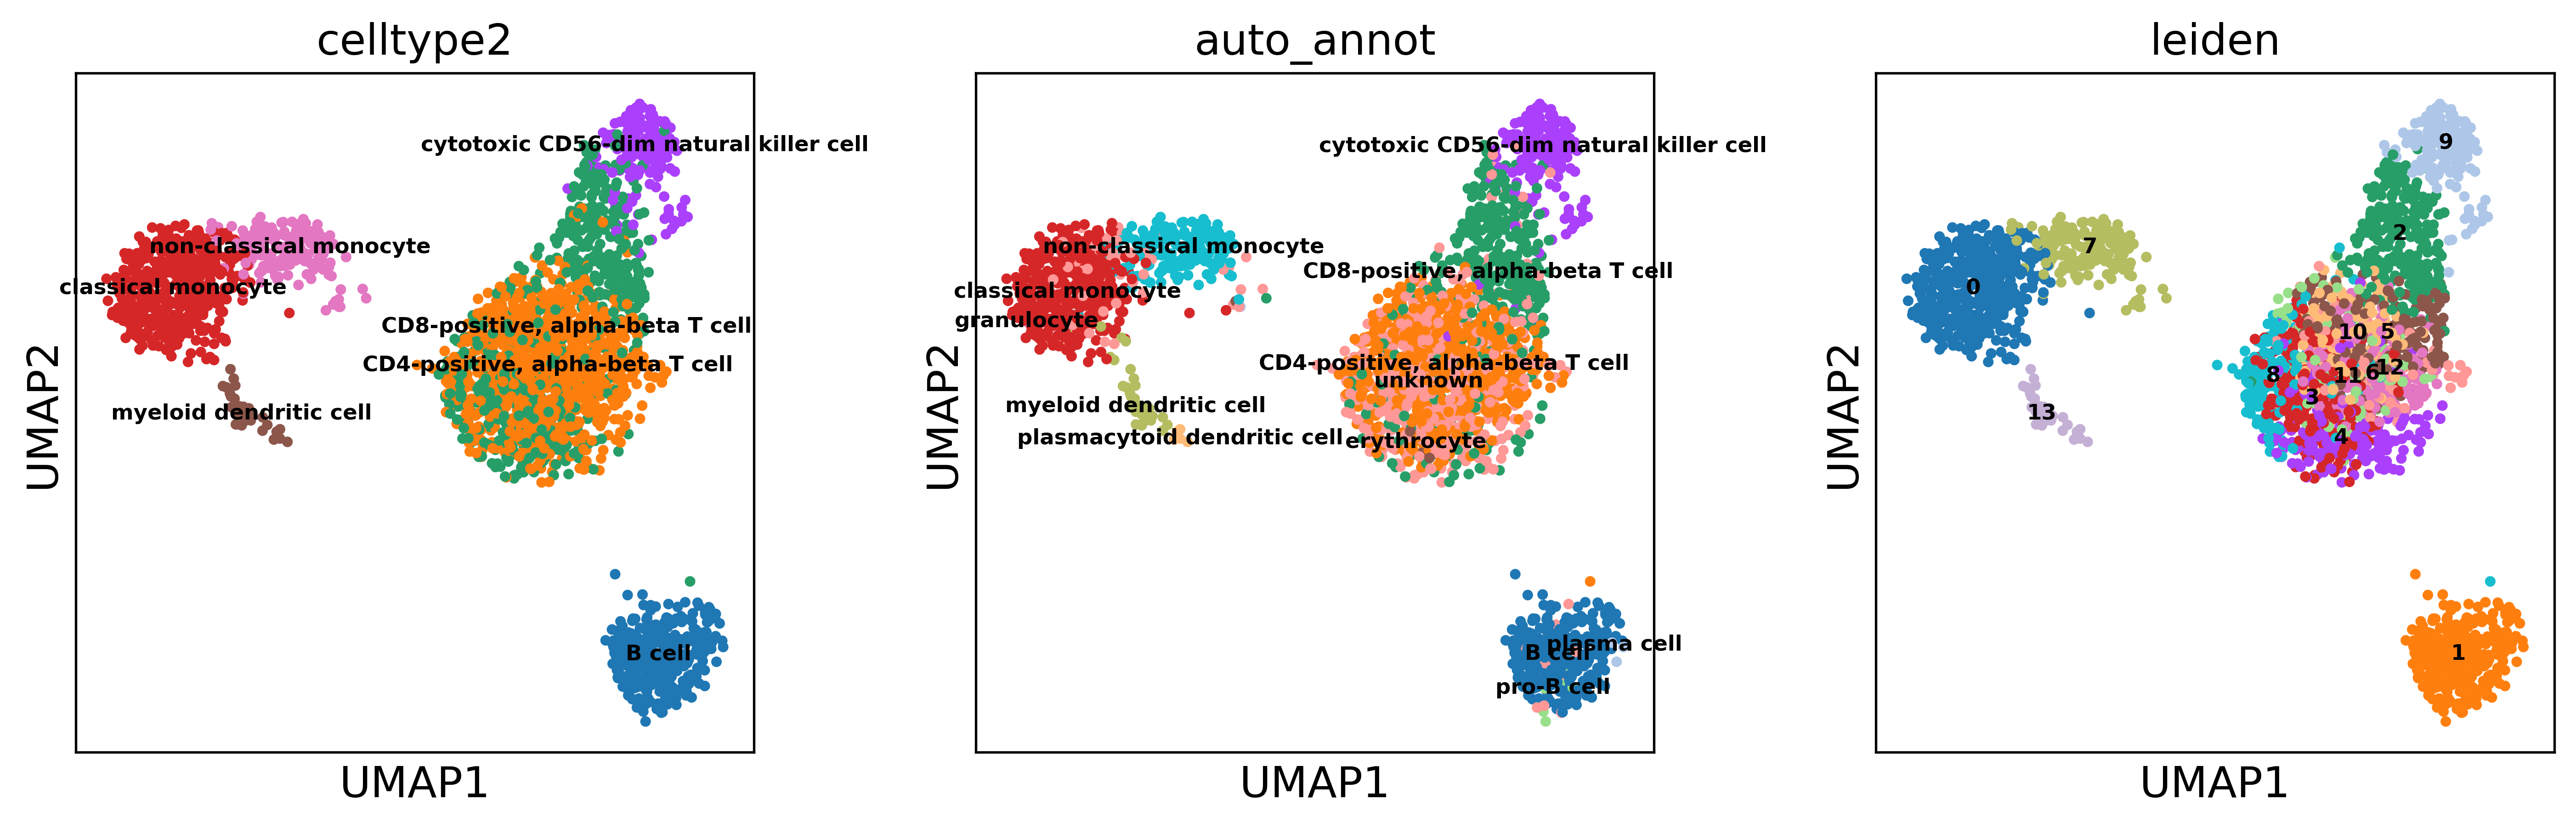

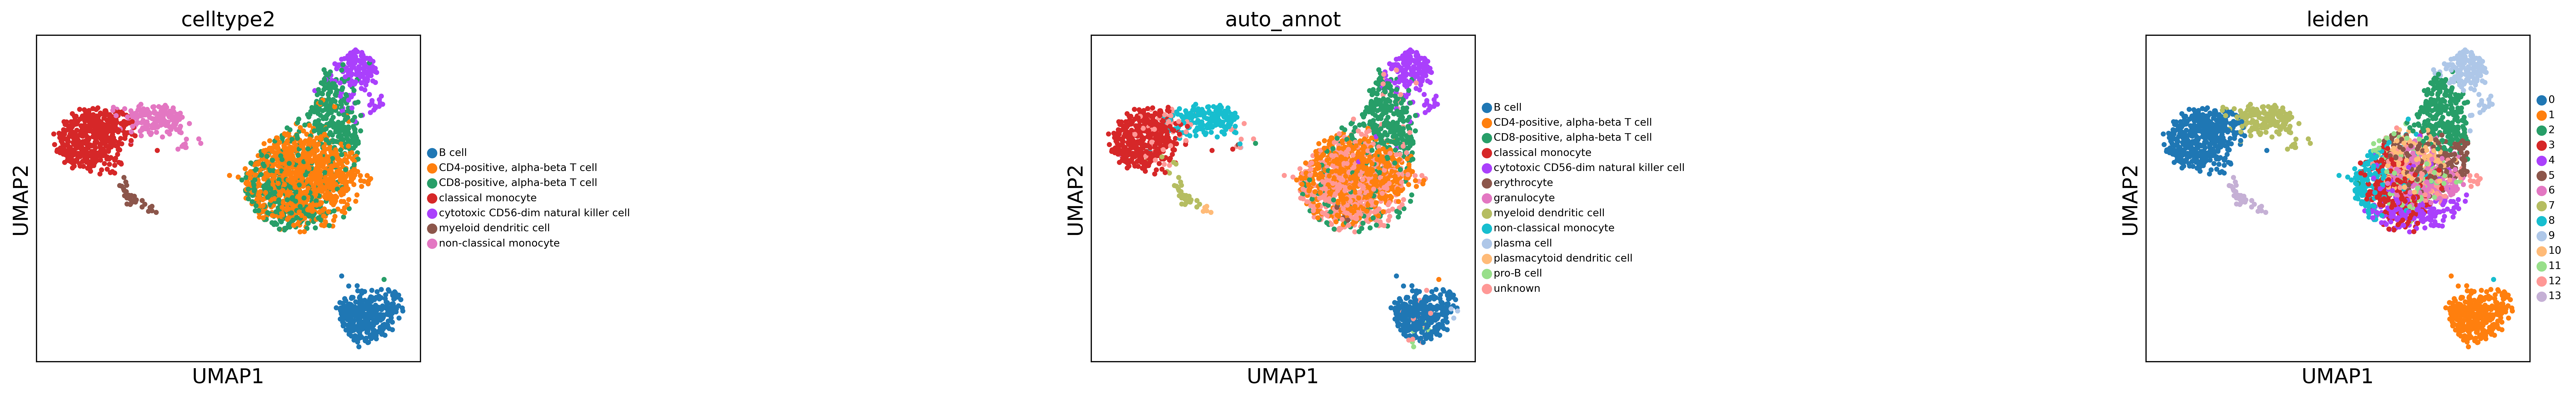

Confusion matrix, without normalization
Normalized confusion matrix


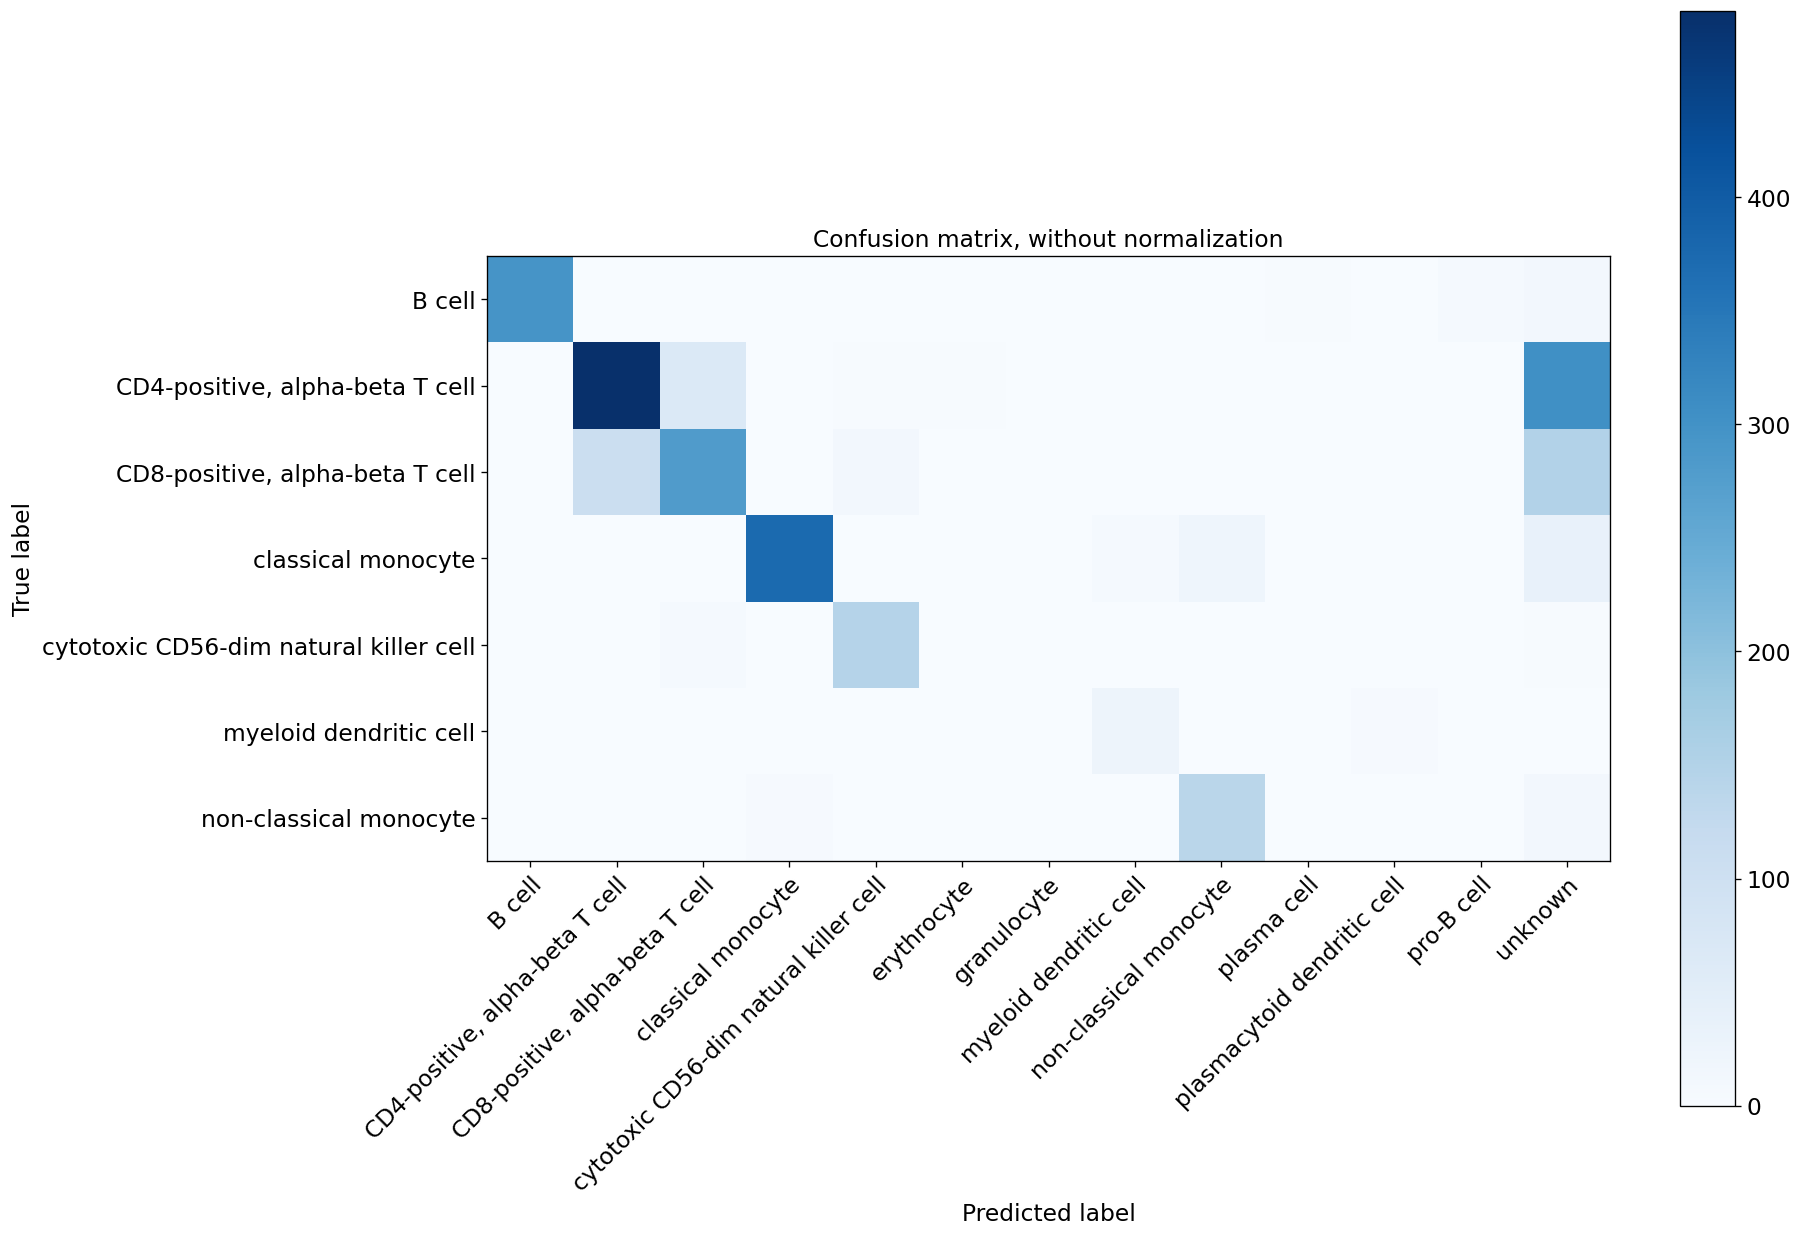

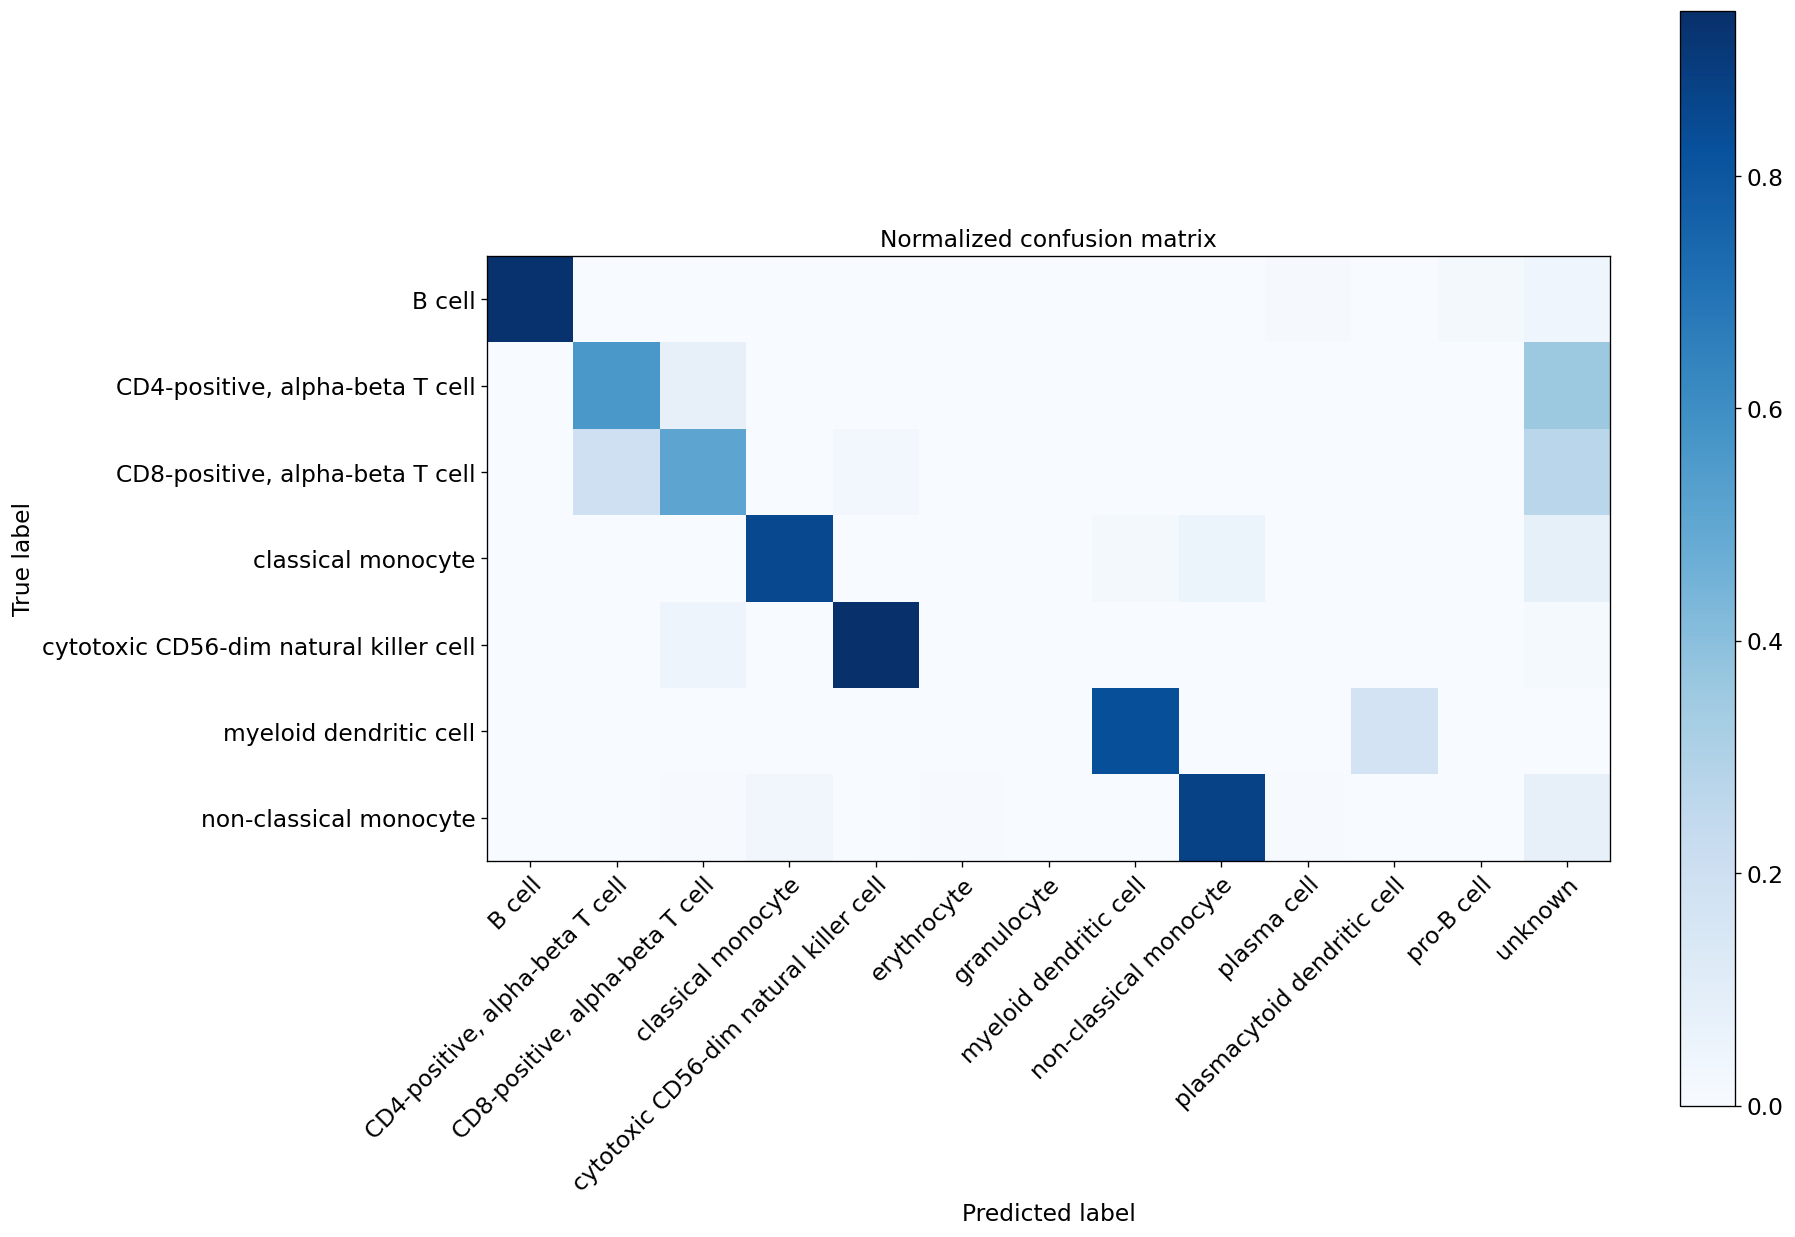

In [38]:
%matplotlib inline
sc.settings.set_figure_params(dpi=90)
bc.tl.auto_annot.report(adata_predicted_threshold, celltype, method, analysis_name, False, merge, use_raw, genes_to_use, clustering = 'leiden')

In [39]:
sc.settings.set_figure_params(dpi=80) 
plt.rcParams['svg.fonttype'] = 'none'
sc.pl.umap(adata_predicted_threshold, color=[celltype, 'auto_annot', 'leiden'], legend_loc='on data',legend_fontsize=7,  save= '.fig3_threshold_ondata_level2.svg')
sc.pl.umap(adata_predicted_threshold, color=[celltype, 'auto_annot', 'leiden'],legend_fontsize=7, wspace = 1.4, save = '.fig3_threshold_level2.svg')


Confusion matrix, without normalization
Normalized confusion matrix


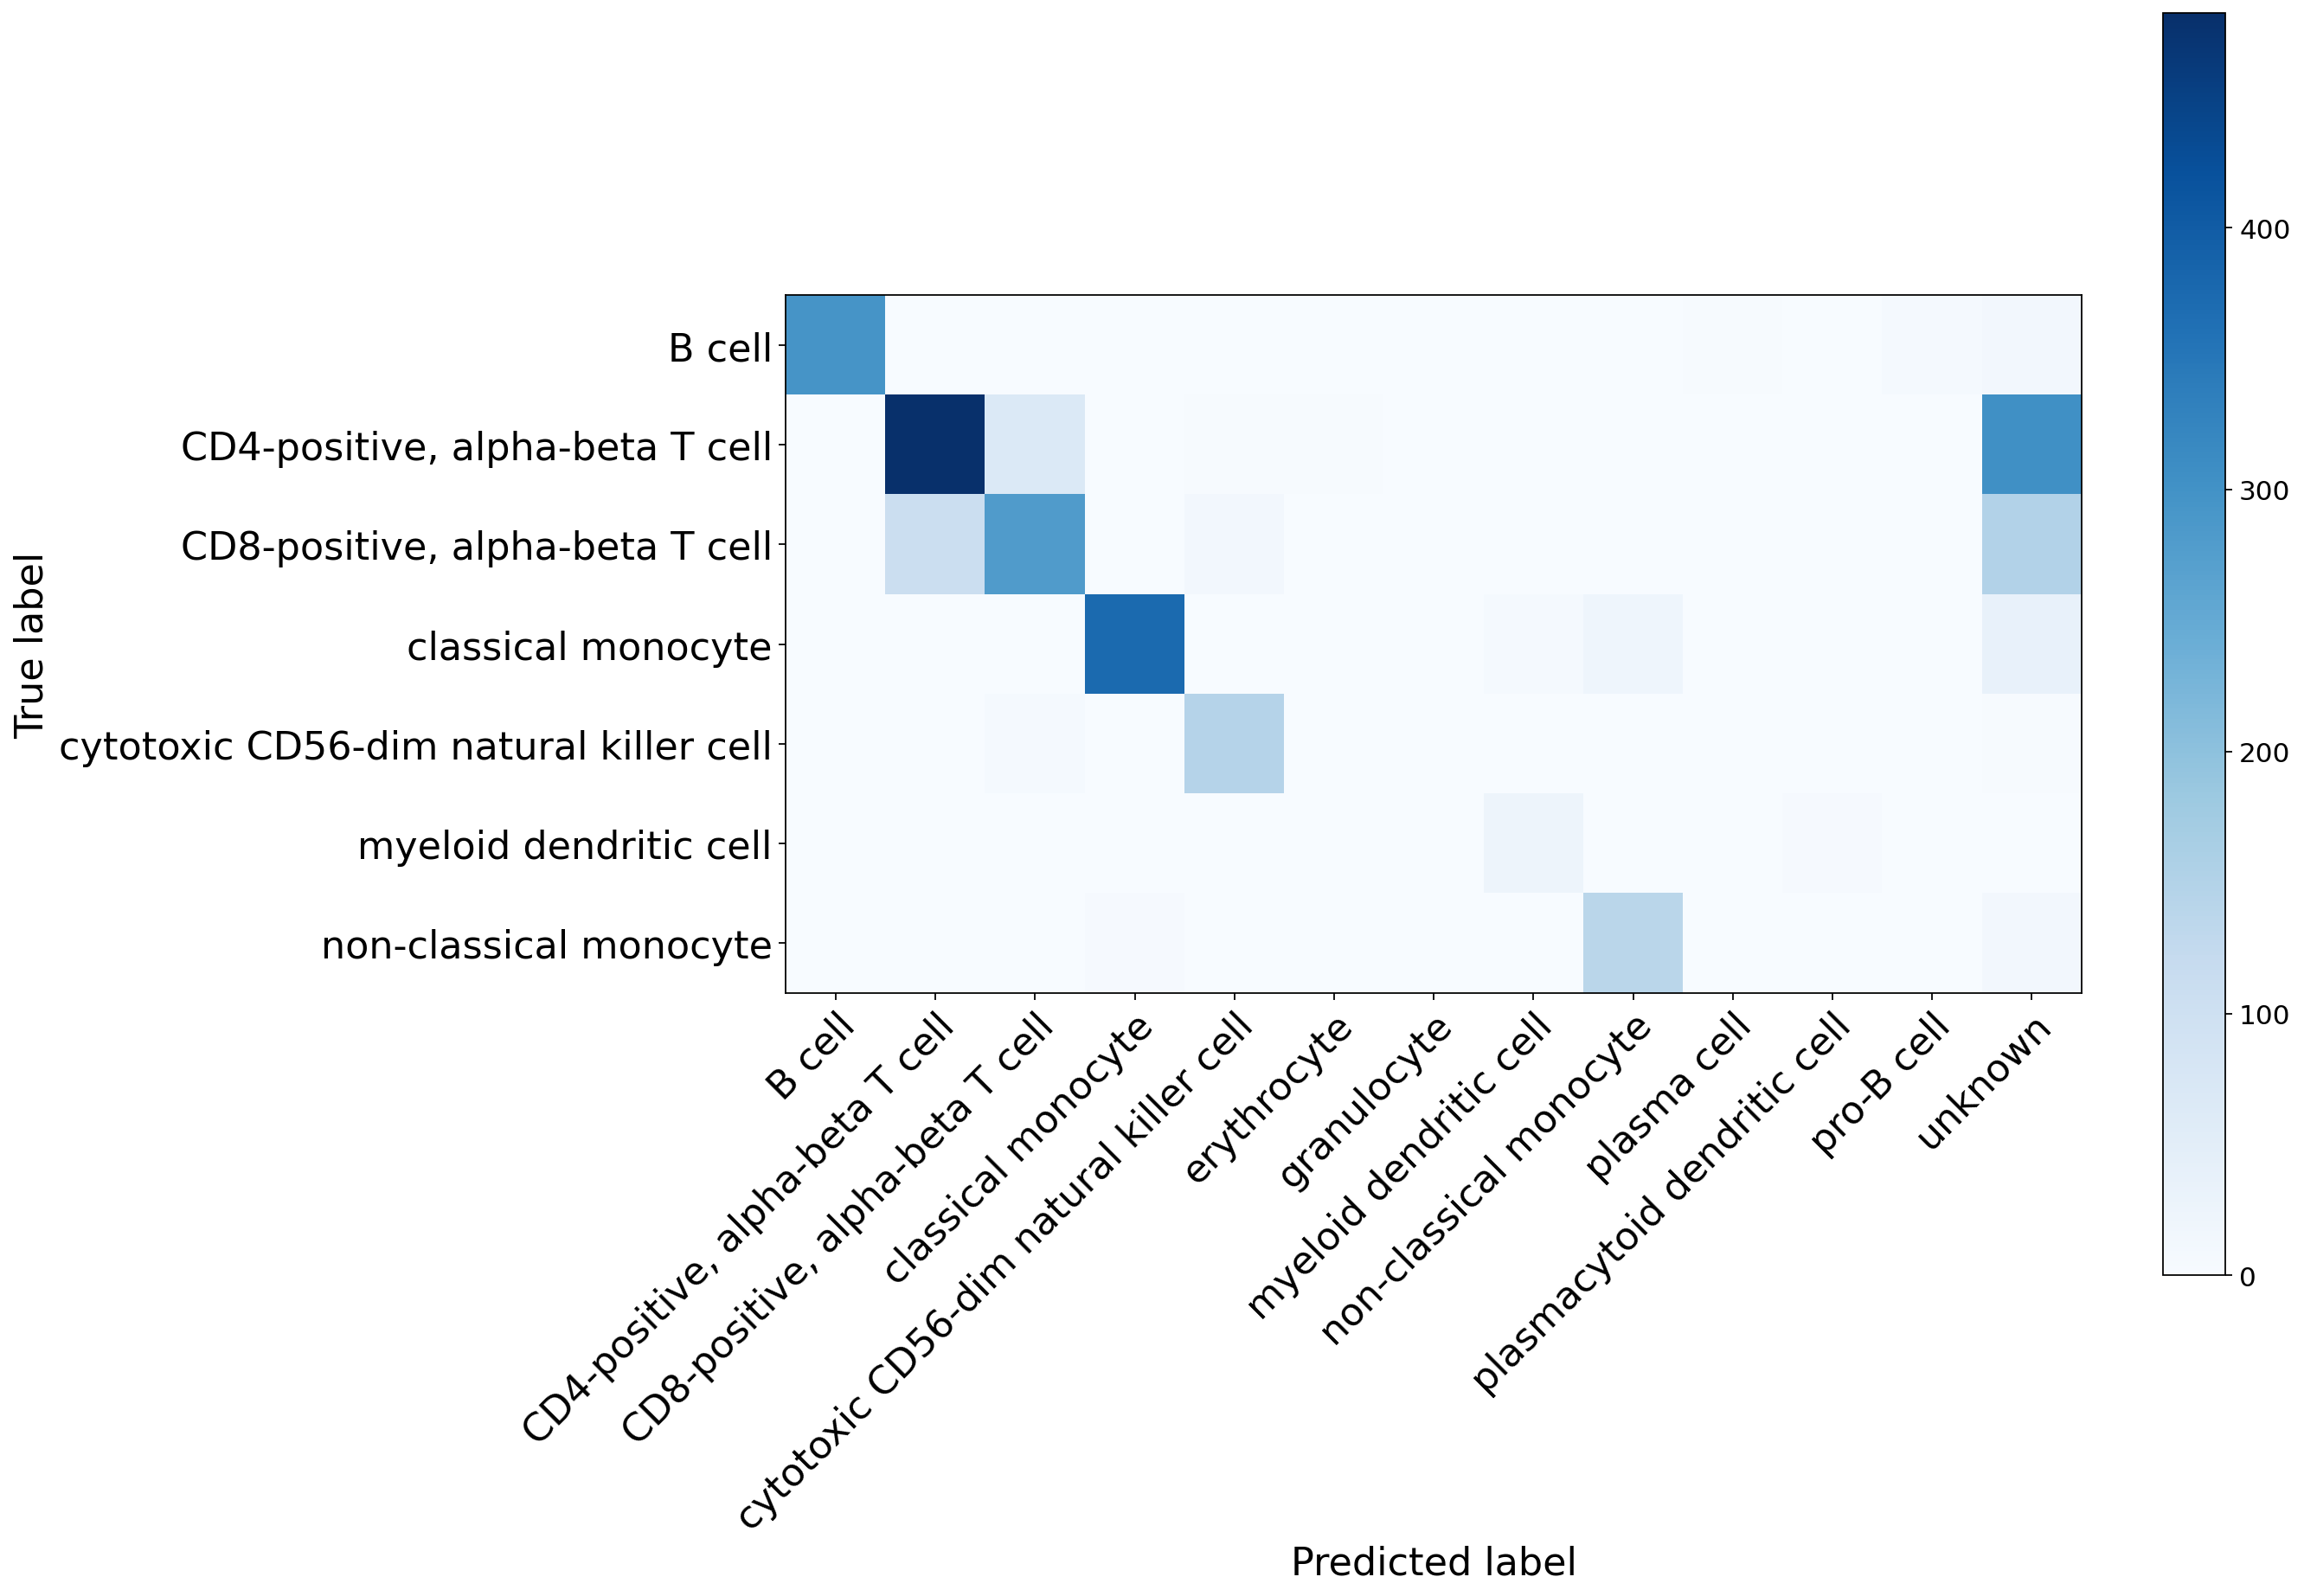

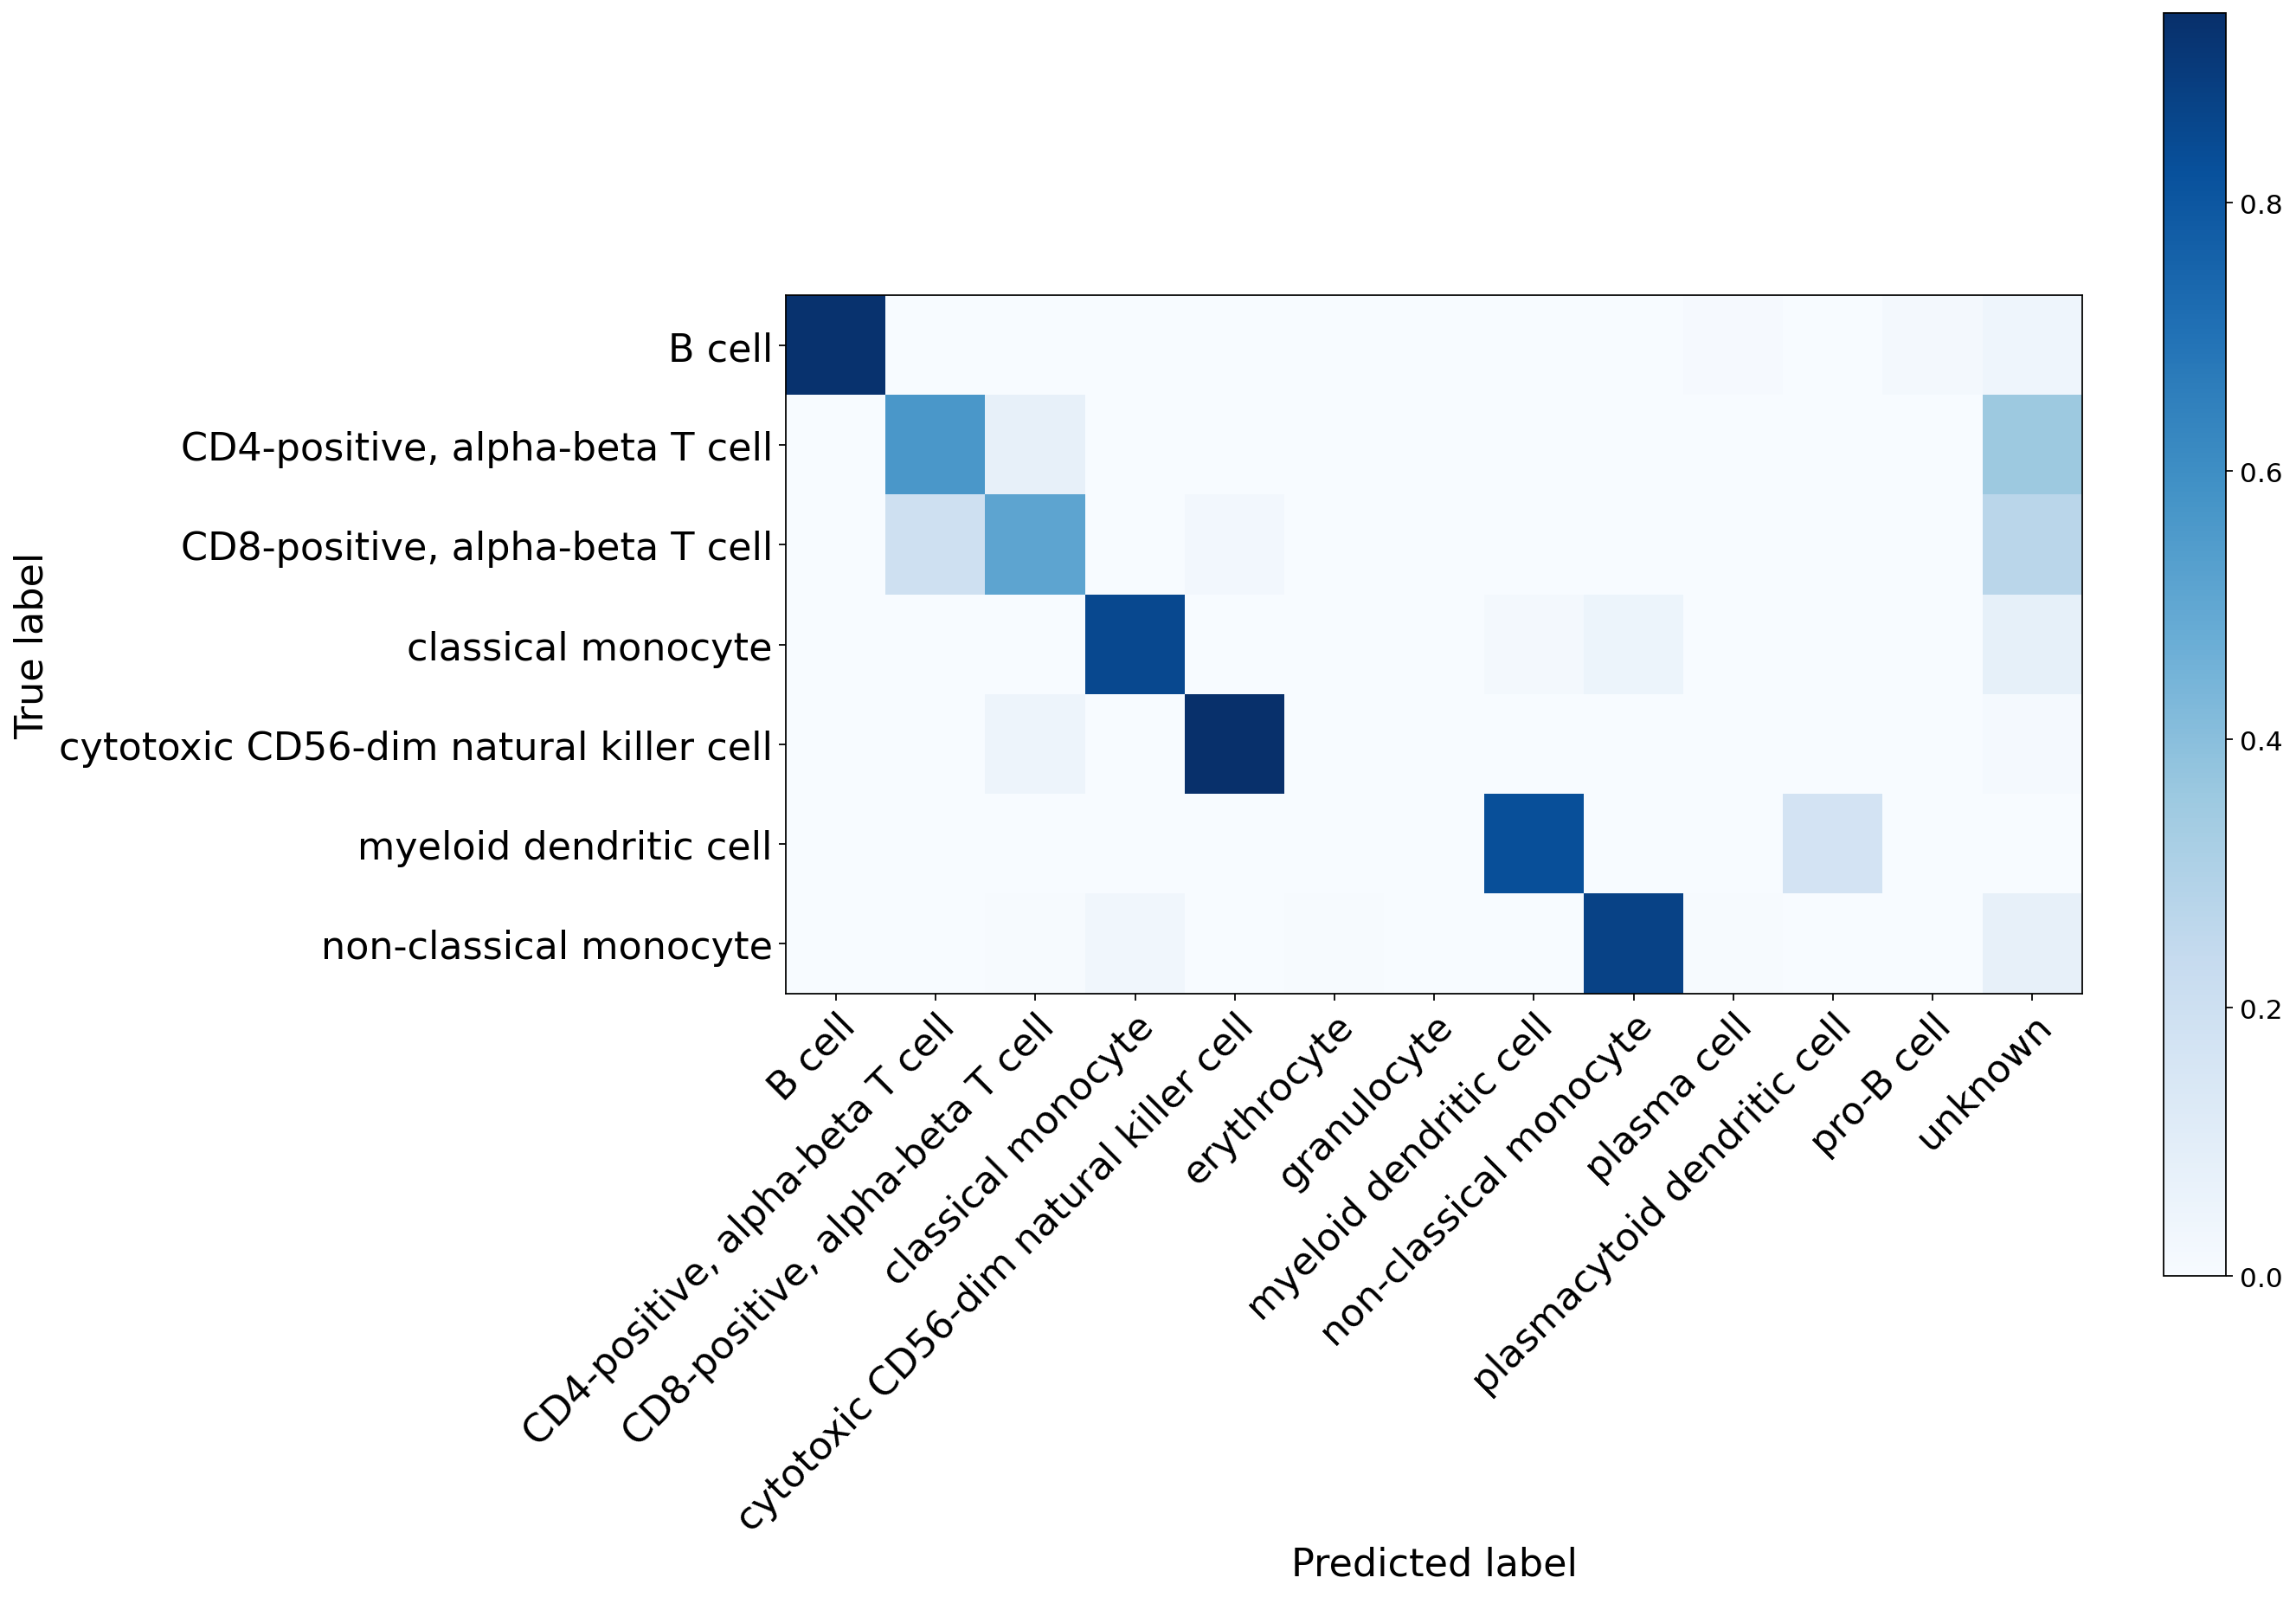

In [48]:
# make conf matrices (4)
sc.settings.set_figure_params(dpi=80) 
plt.rcParams['svg.fonttype'] = 'none'
class_names =  np.unique(np.concatenate((adata_predicted_threshold.obs[celltype], adata_predicted_threshold.obs['auto_annot'])))
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(adata_predicted_threshold.obs[celltype], adata_predicted_threshold.obs['auto_annot'], title = " ", classes=class_names, celltype=celltype ,numbers = False, adata_predicted = adata_predicted_threshold, asymmetric_matrix = True)
plt.savefig(os.path.join('fig3_confusion_matrix_threshold_nonnormalised_level2.svg'))

# Plot normalized confusion matrix with numbers
plot_confusion_matrix(adata_predicted_threshold.obs[celltype], adata_predicted_threshold.obs['auto_annot'], title = " ", classes=class_names,celltype=celltype,  normalize=True, numbers = False, adata_predicted = adata_predicted_threshold, asymmetric_matrix = True)
plt.savefig(os.path.join('fig3_confusion_matrix_threshold_normalised_level2.svg'))


# let's check if the differences in annotation make sense

In [41]:
 ## PROVIDED WITH BESCA
root_path = os.getcwd()

gmt_file_IMM= os.path.split(root_path)[0] + '/besca/besca/datasets/genesets/HumanCD45p_scseqCMs6.gmt'
bc.tl.sig.combined_signature_score(adata_predicted, gmt_file_IMM)


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/c/Users/luisw/OneDrive/Dokumente/BEDA/bescafinal/besca_publication_results/hematopoietic/besca/besca/datasets/genesets/HumanCD45p_scseqCMs6.gmt'

In [ ]:
adata_predicted.var_names

In [ ]:
scores = [x for x in adata_predicted.obs.columns if 'CD45' in x]
scores

Indeed it seems like the classification of B cells is an improvement, whereas the varieties of T cells pose difficulties.

In [ ]:
sc.pl.umap(adata_predicted, color= ["score_HumanCD45p_scseqCMs6_MemB_scanpy", "score_HumanCD45p_scseqCMs6_NaiveB_scanpy","IL7R", "CD8A"], ncols = 2, wspace = 0.4, color_map = 'viridis',save= '.fig3_markers_new.svg')

In [ ]:
sc.pl.umap(adata_predicted, color= ["IL7R"], ncols = 2, wspace = 0.4, color_map = 'viridis', save= '.fig3_IL7R.svg')